# 4. Multivariate Analysis

> Before constructing a composite indicator, it is essential to explore the relationships, redundancies and latent structure among your variables. 
> — *Handbook on Constructing Composite Indicators: Methodology and User Guide*

In this notebook I will:

1. **Visualise** the pairwise relationships within each of the five sub-indices (Financial Strength, Growth Potential, Market Performance, Risk & Volatility, Liquidity & Trading) by producing scatter-matrix plots.  
2. **Quantify** the strength and direction of associations **within** each sub-index and **across** the full 30-variable dataset using Pearson correlation matrices and heat maps.  
3. **Check factorability** of the data with the Kaiser–Meyer–Olkin (KMO) measure and Bartlett’s test of sphericity to confirm that PCA or Factor Analysis is appropriate - Section 4 in the Handbook.  
4. **Run Principal Component Analysis (PCA)**  
   - A **global PCA** on all 30 indicators to determine overall dimensionality and identify major axes of variation.  
   - **Sub-index PCA** on each conceptual group to test whether its indicators do indeed cluster together. 
5. **Assess internal consistency** of each sub-index using Cronbach’s α.  
6. **Detect redundancy** and potential clusters of indicators by performing hierarchical clustering (Ward’s method) on the correlation matrix.  
7. **Summarise** my findings to guide how I will weight and aggregate indicators in the next stages.

---

**Why I’m doing this**  
- **Redundancy check**: to remove or merge highly correlated indicators that do not add unique information.  
- **Dimensionality**: to learn how many latent factors truly drive the data.  
- **Coherence**: to confirm that each of my five sub indices behaves as a statistically distinct group. 
- **Weighting guidance**: to decide what weights will make sense for the final aggregation - equally weighted, or based on PCA loadings, or based off the knowledge I have.

## 4.1. Load & Standardize Data

In this step I load the fully‐imputed CSIAI input (`csiai_input_complete.parquet`), set the ticker as index, and apply z-score standardization to all 30 indicators. This prepares the data for PCA, factor analysis, and clustering by ensuring each variable has zero mean and unit variance.

In [3]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Paths
ROOT = Path("..")
DATA_DIR = ROOT / "data" / "processed"
INPUT_PATH = DATA_DIR / "csiai_input_complete.parquet"
OUTPUT_Z = DATA_DIR / "csiai_input_zscores.parquet"

# Load the pooled, complete dataset
df = pd.read_parquet(INPUT_PATH)

if "ticker" in df.columns:
    df = df.set_index("ticker")

# Standardize all the 30 input variables
scaler = StandardScaler()
z_values = scaler.fit_transform(df.values)
df_z = pd.DataFrame(z_values, index=df.index, columns=df.columns)

# Export standardized inputs
df_z.to_parquet(OUTPUT_Z)

## 4.2. Scatter‐Plots per Sub-Index

In this section, I explore the relationships among indicators **within each** of the five CSIAI sub-indices:

- **Financial Strength**
- **Growth Potential**
- **Market Performance**
- **Risk & Volatility**
- **Liquidity & Trading**

I begin by loading the Z-scored input data from `data/processed/csiai_input_zscores.parquet` and setting the ticker as the DataFrame index.

Next, I generate a **pair-plot** for each sub-index using Seaborn. These scatter-matrix plots help me:

- Visualize pairwise correlations within each group  
- Identify possible redundancies or unexpected patterns

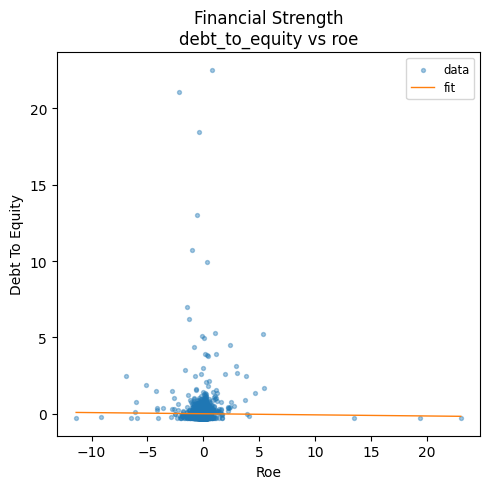

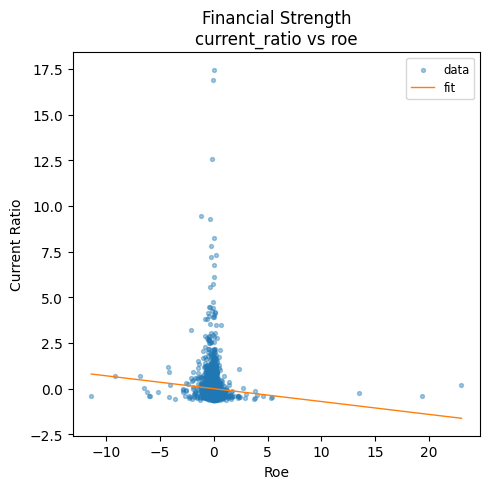

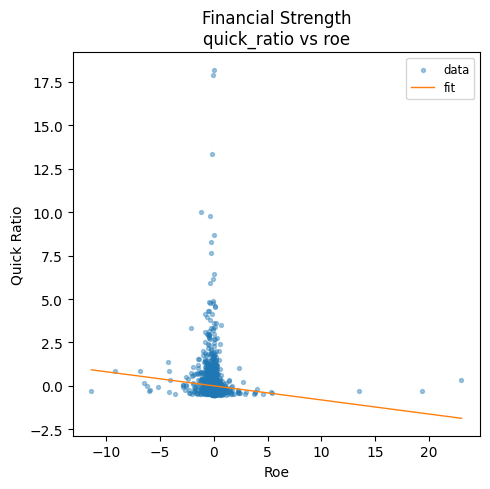

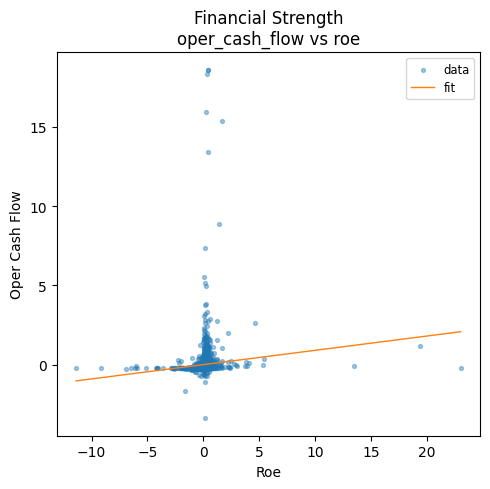

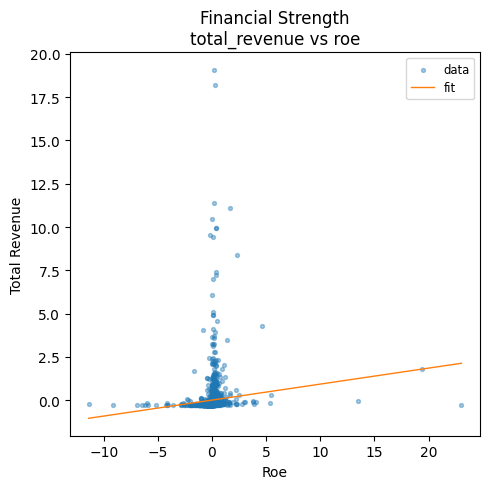

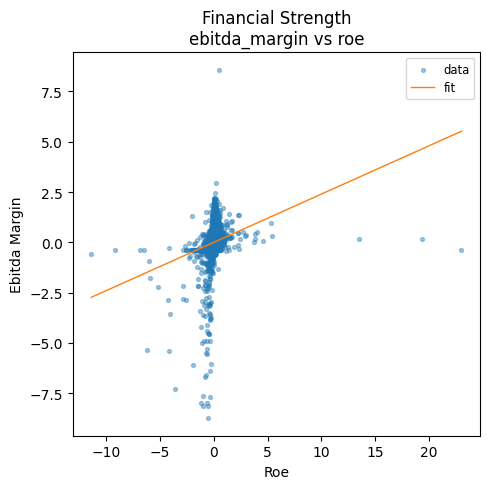

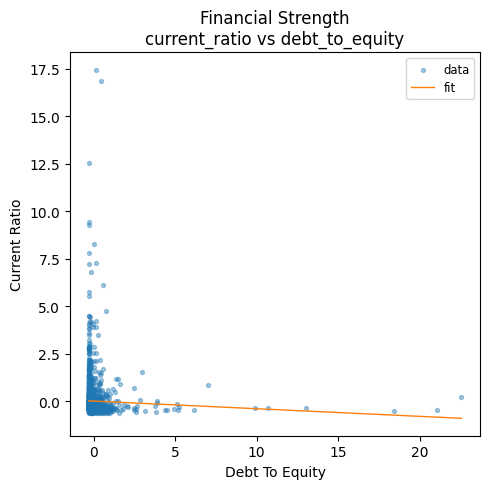

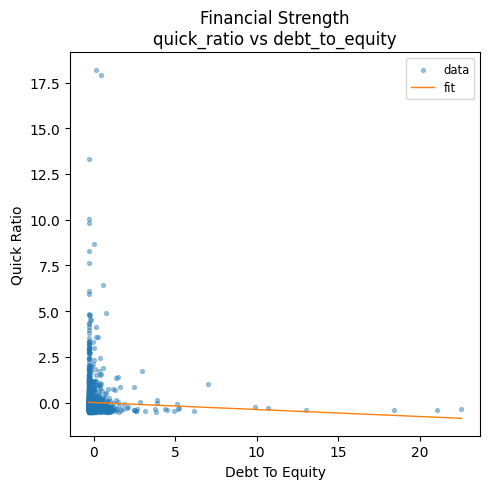

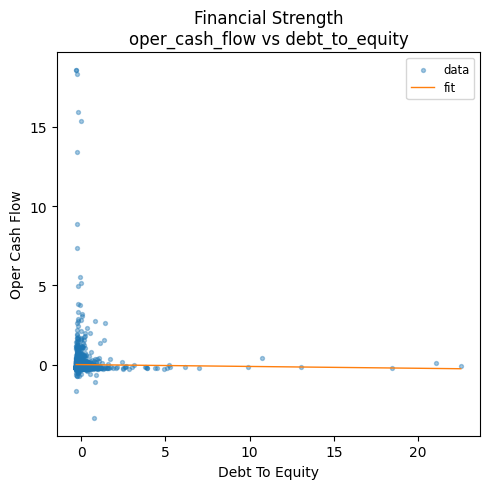

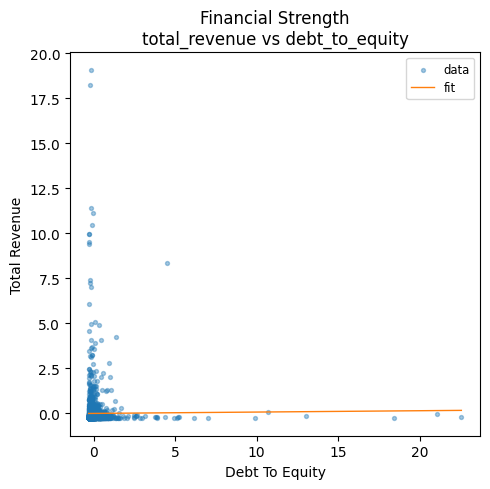

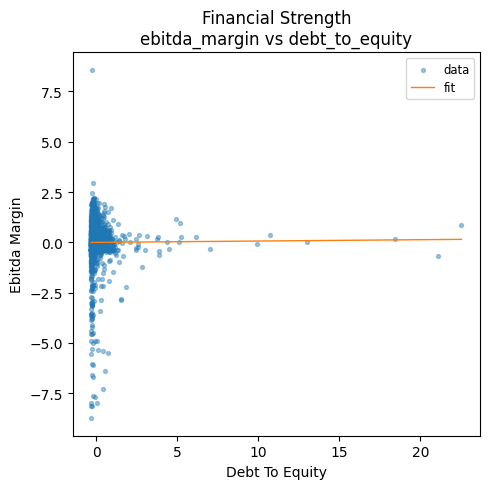

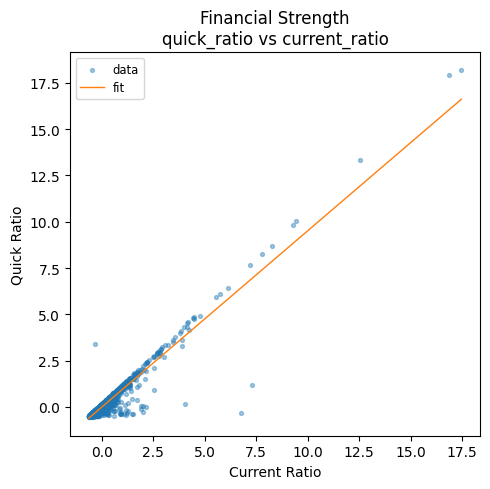

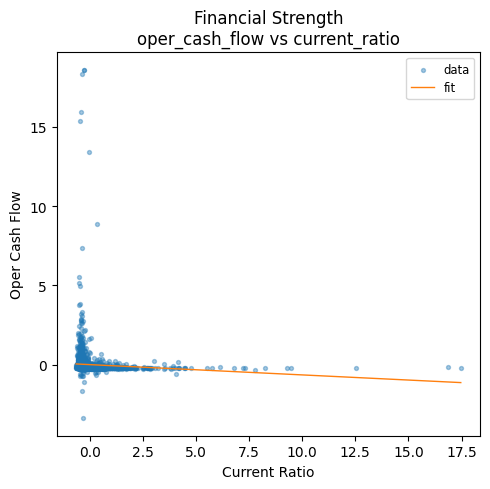

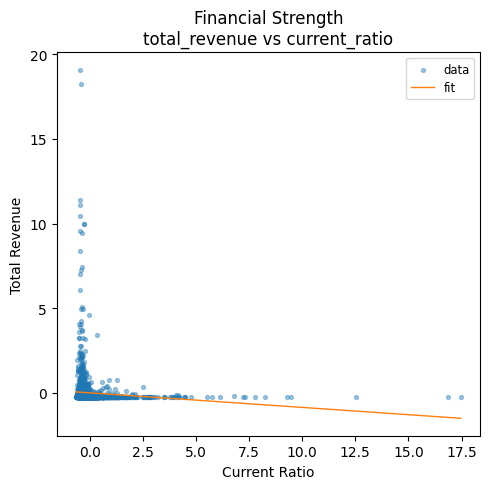

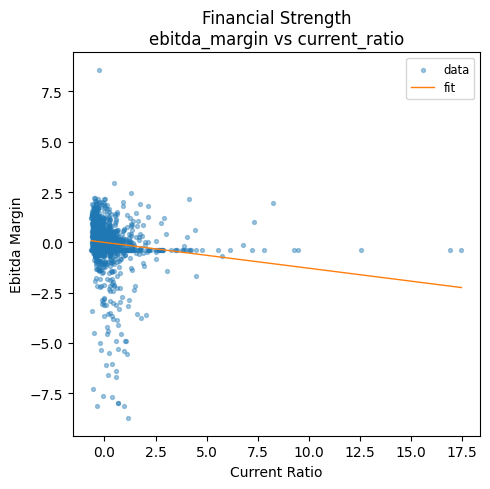

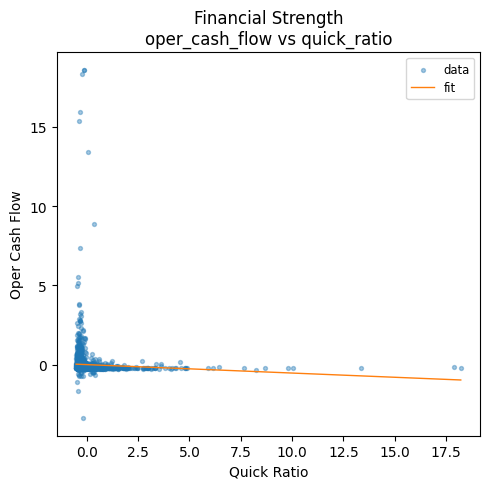

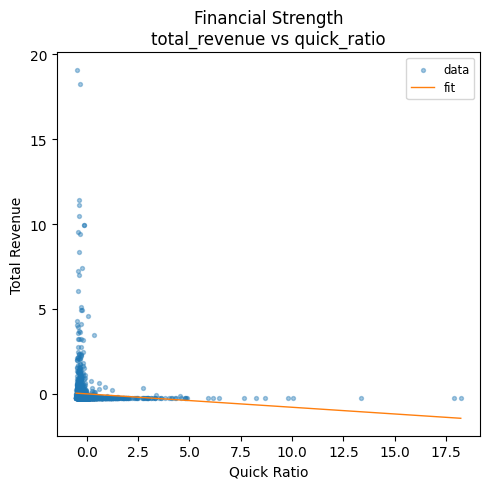

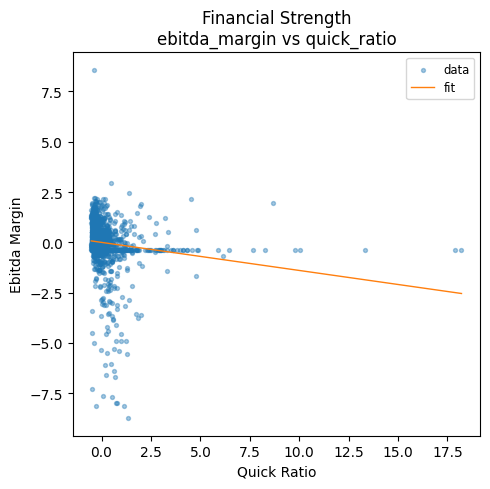

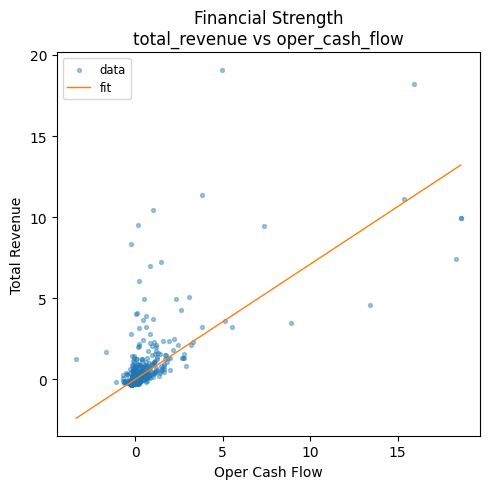

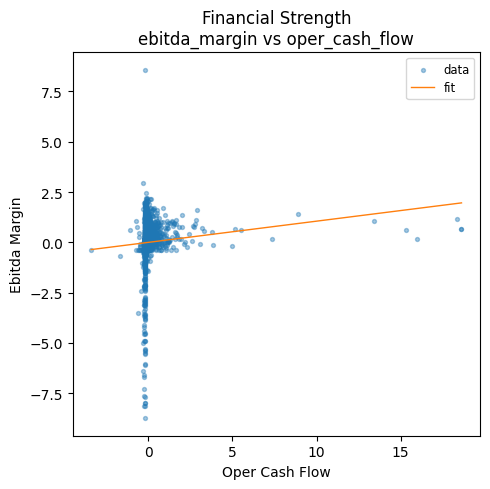

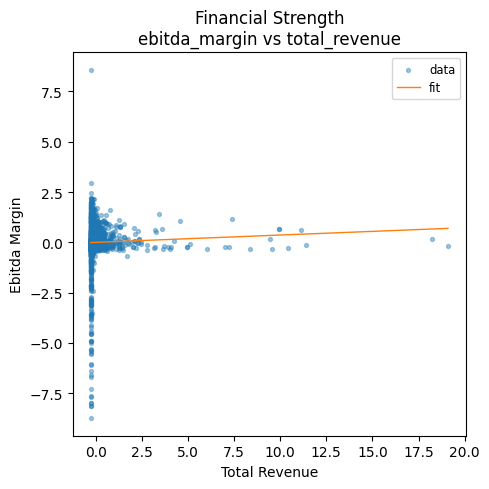

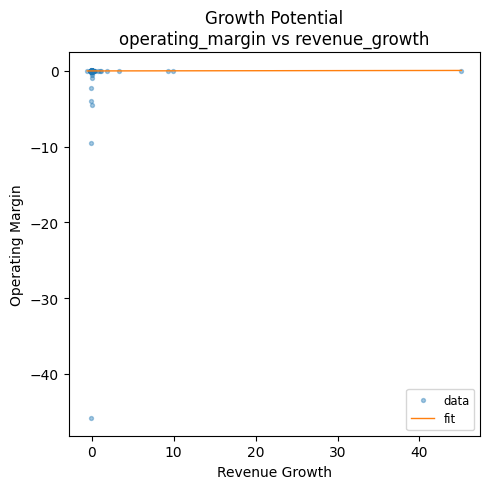

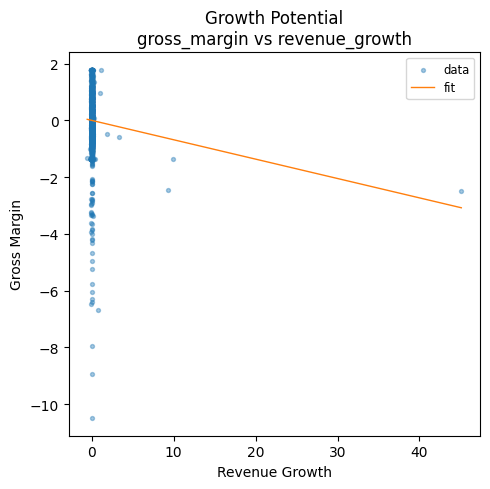

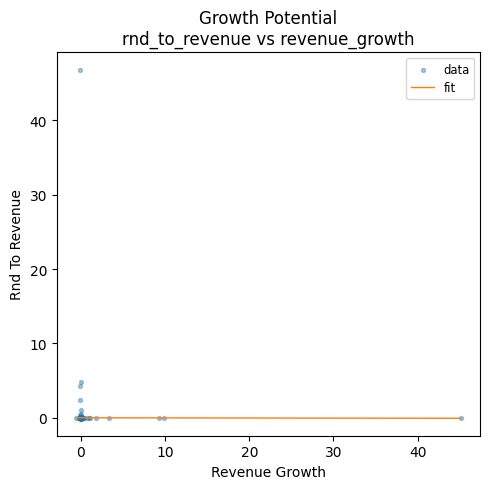

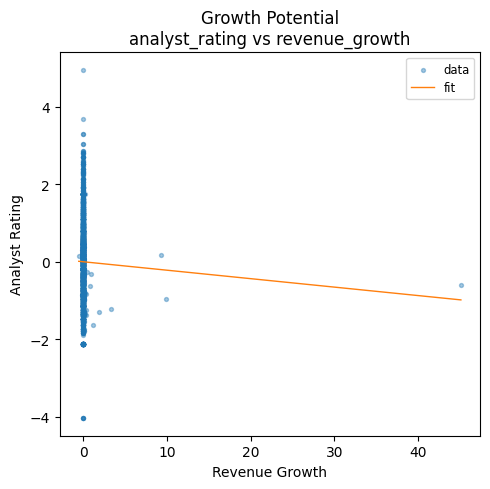

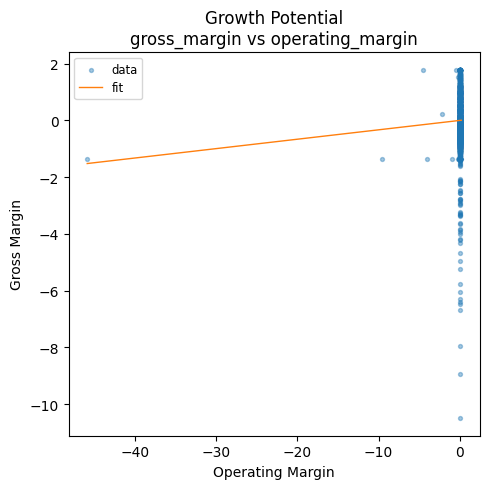

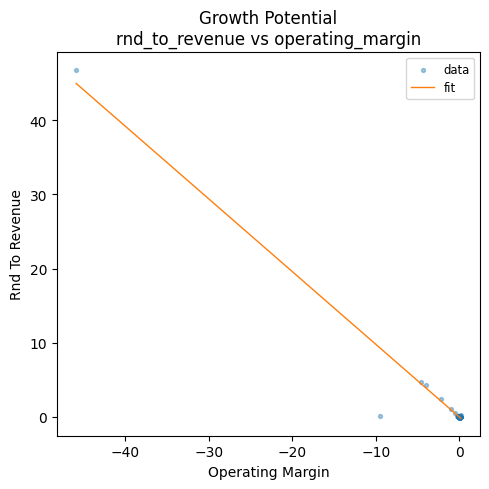

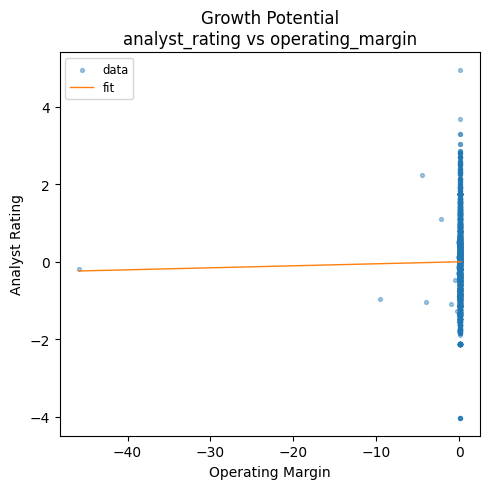

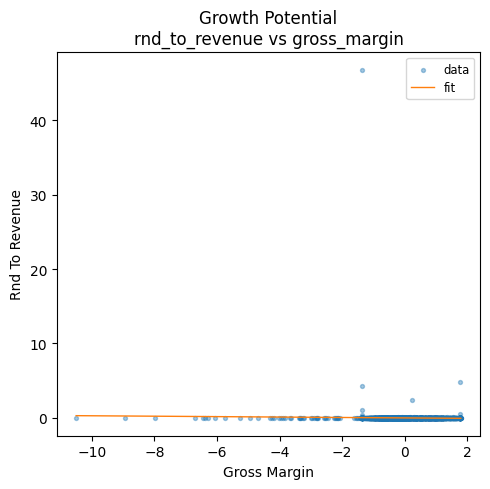

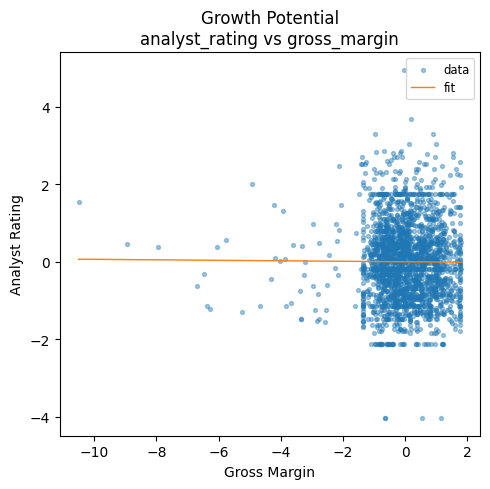

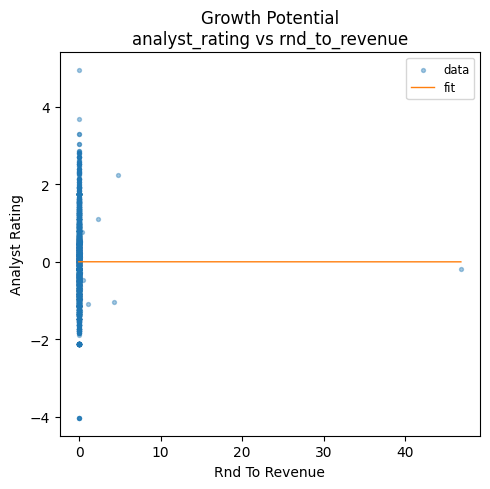

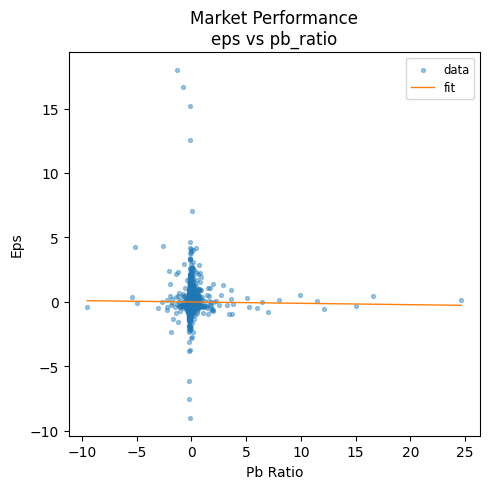

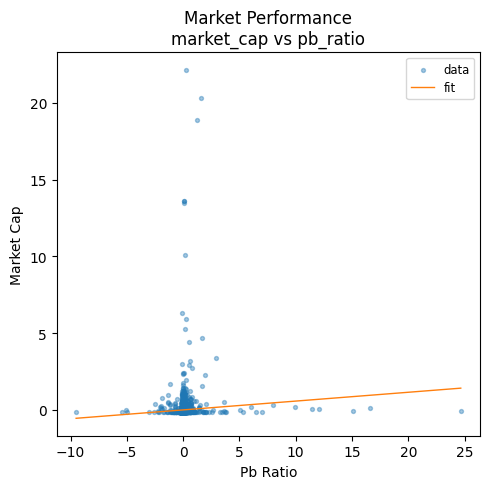

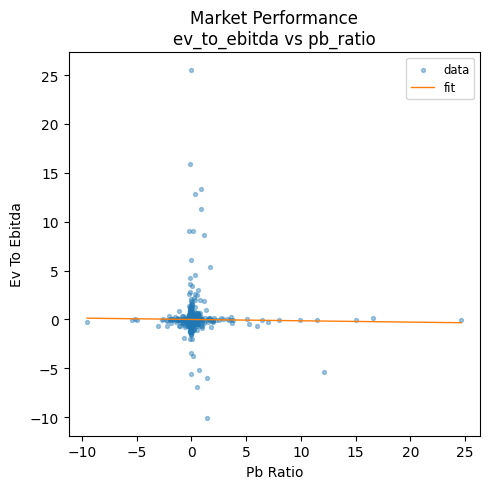

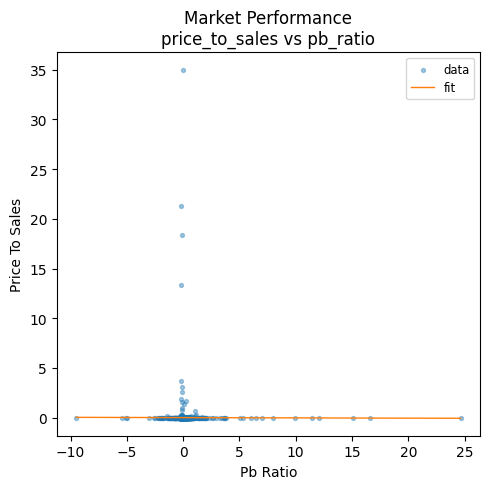

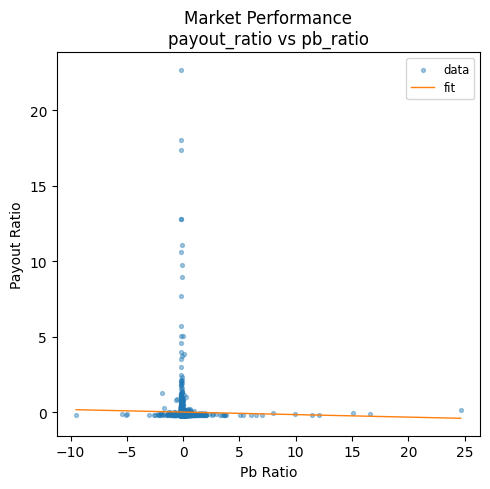

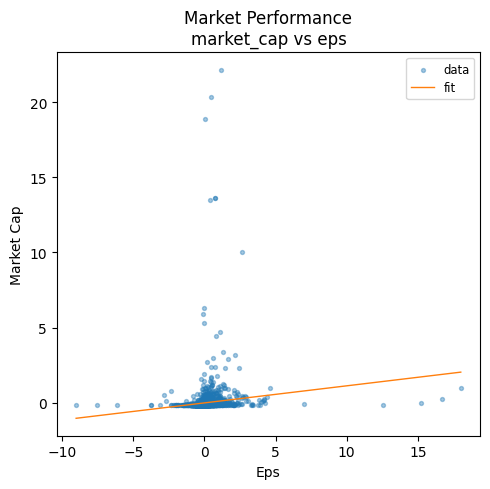

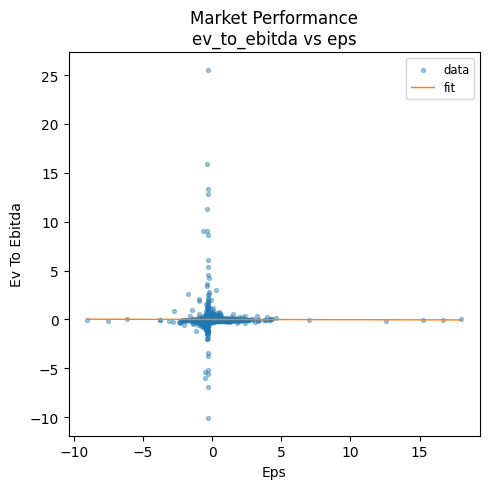

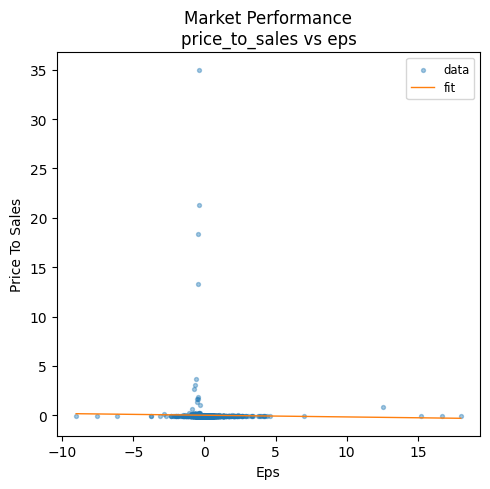

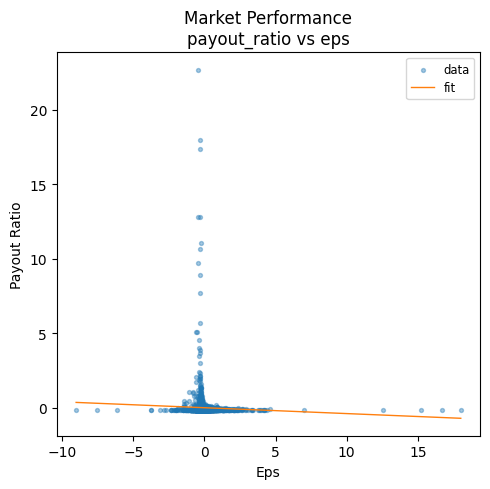

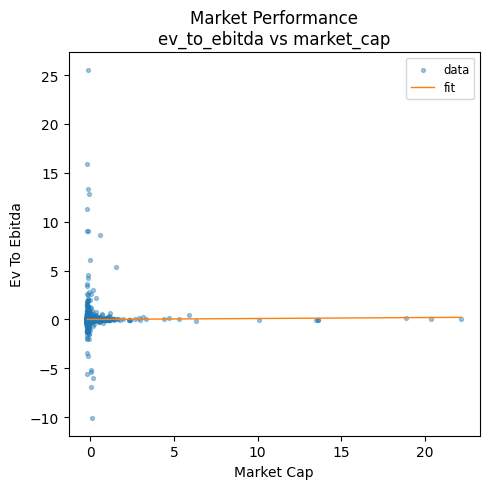

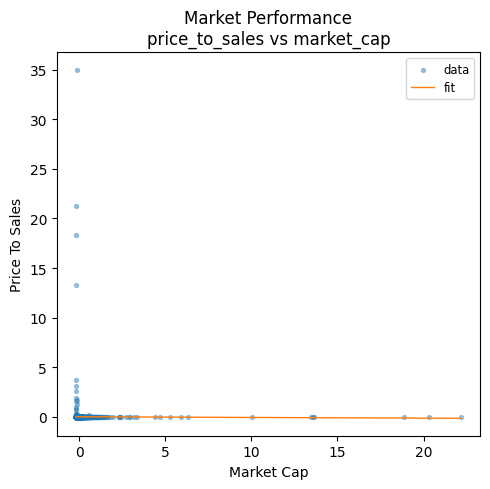

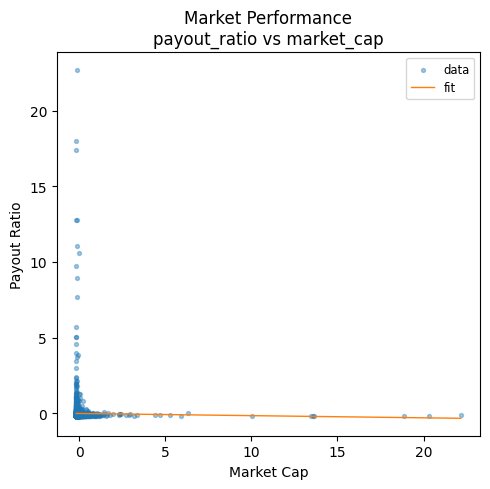

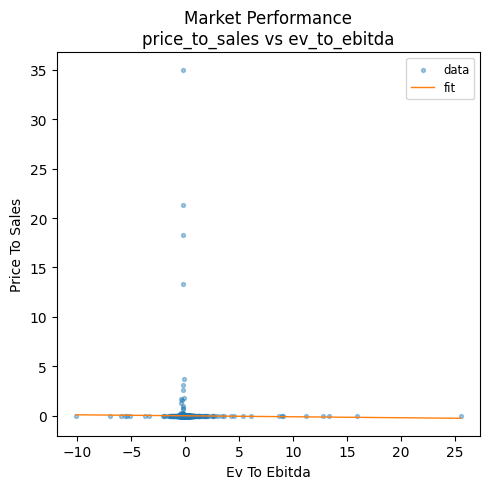

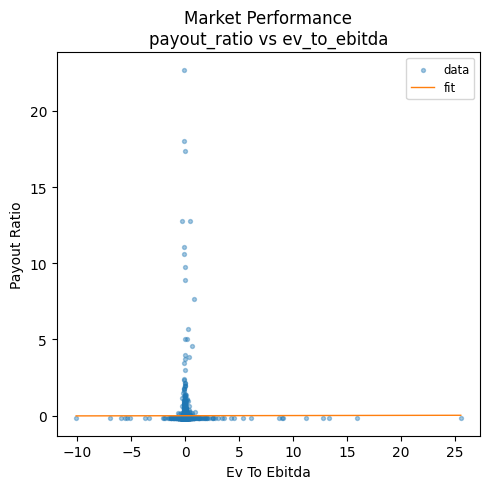

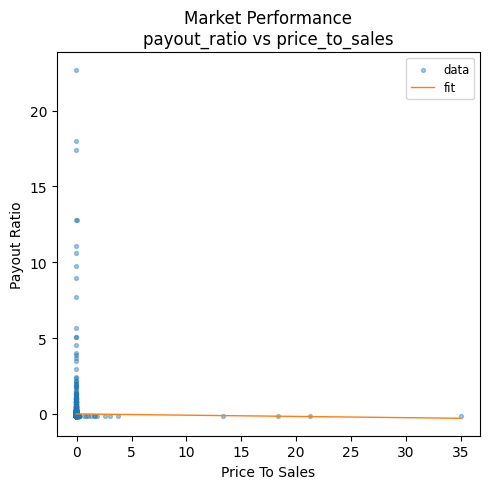

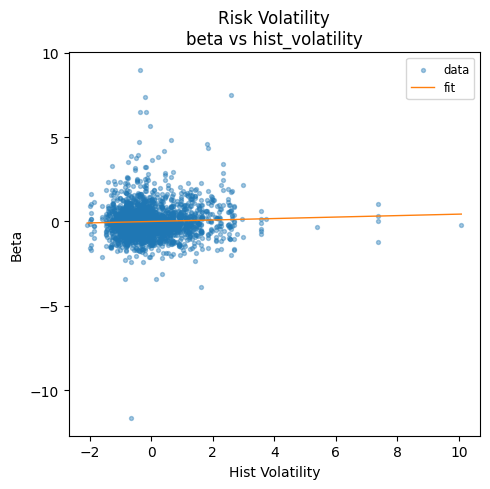

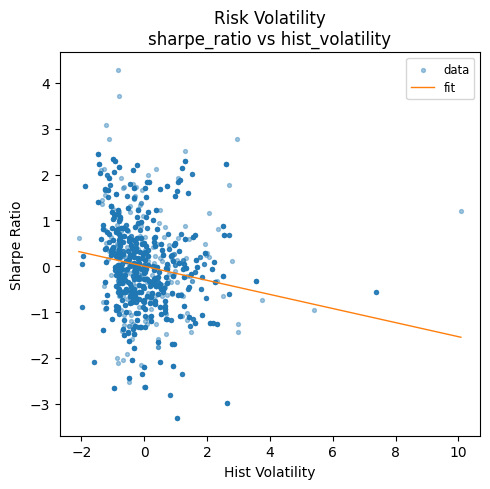

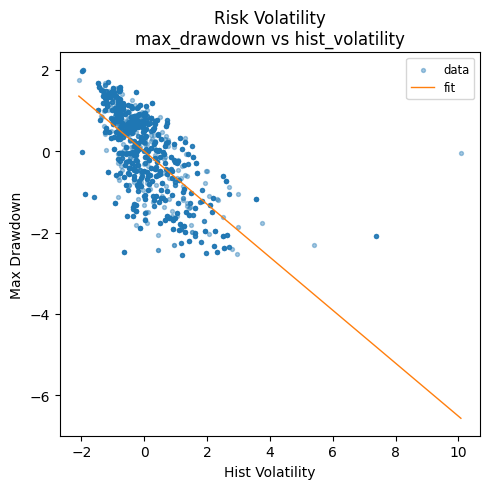

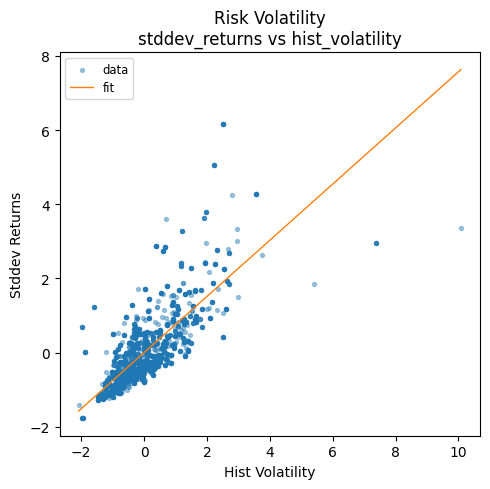

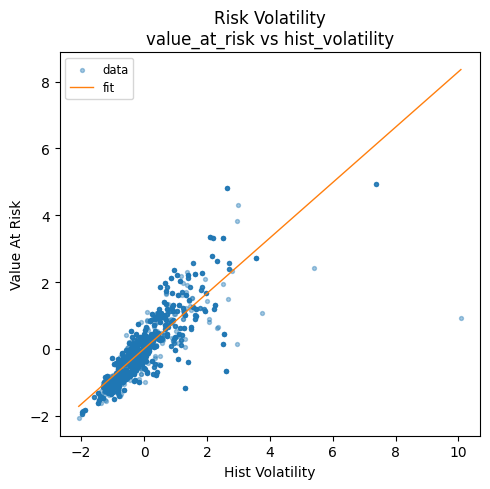

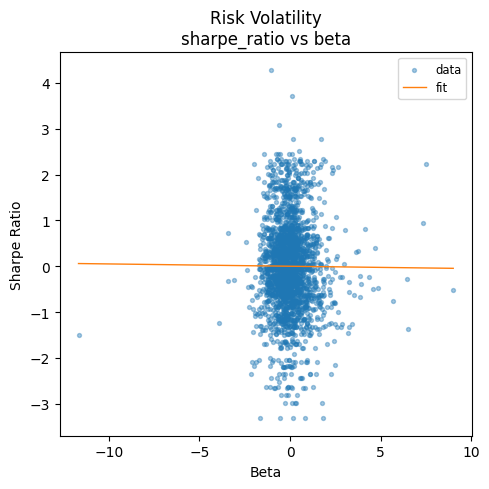

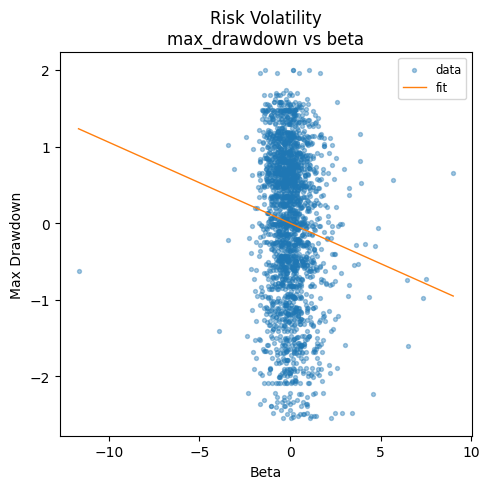

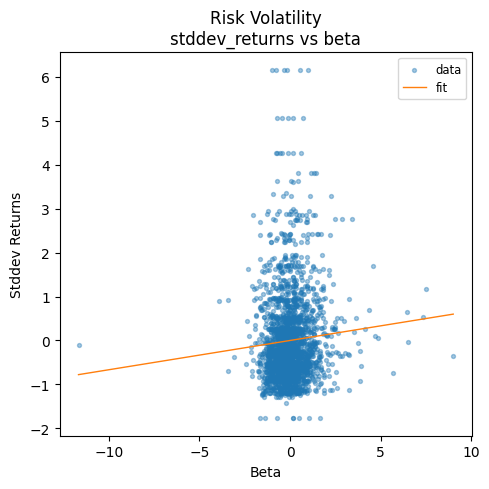

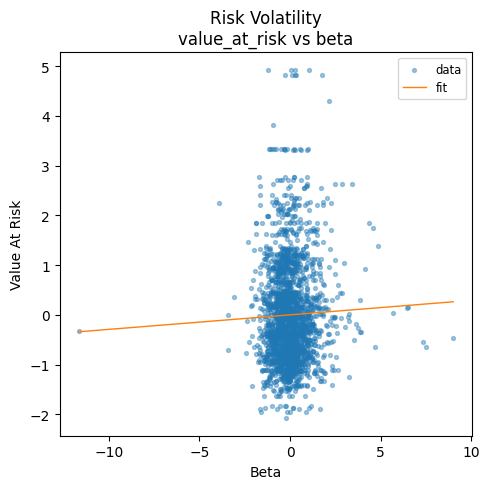

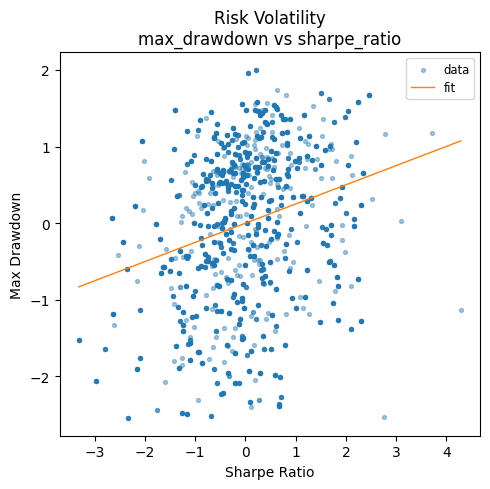

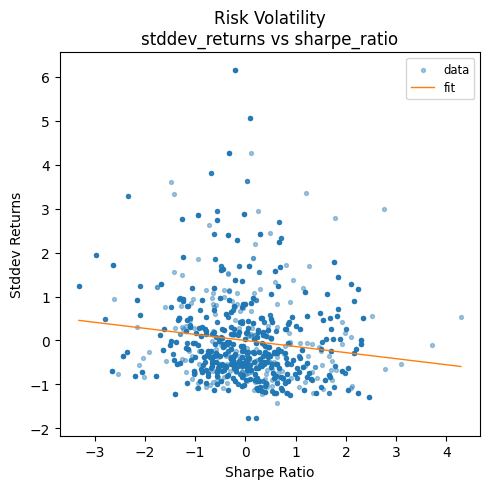

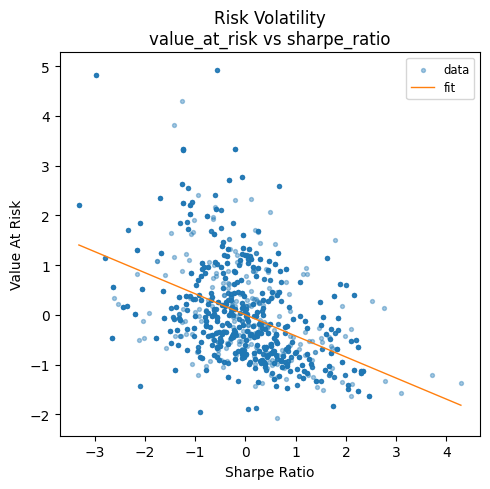

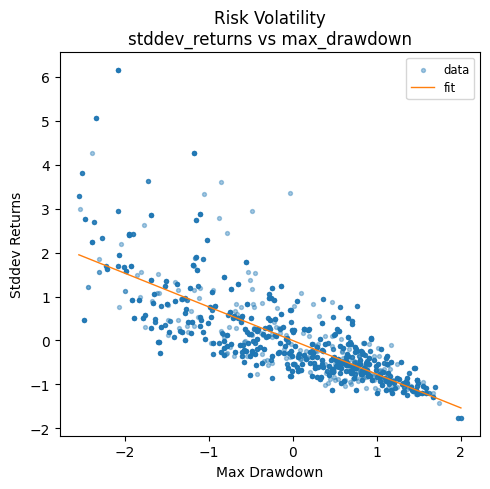

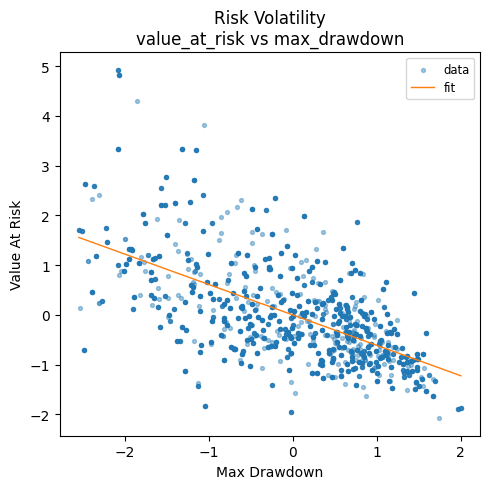

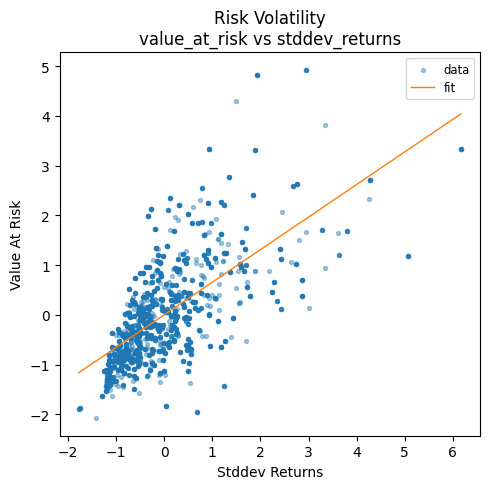

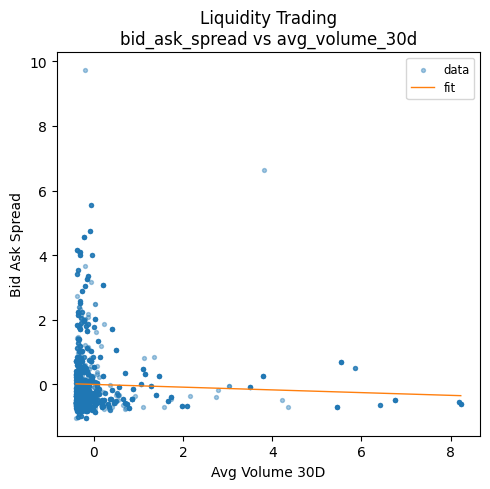

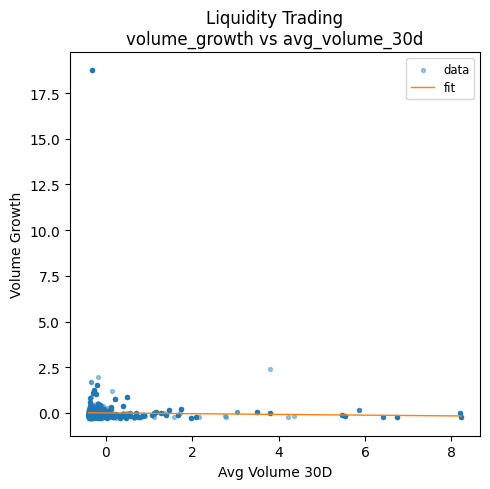

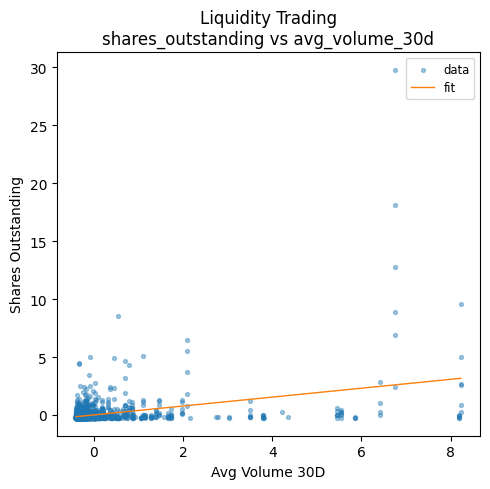

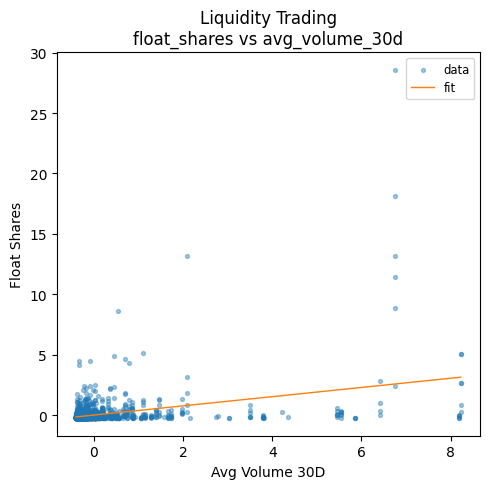

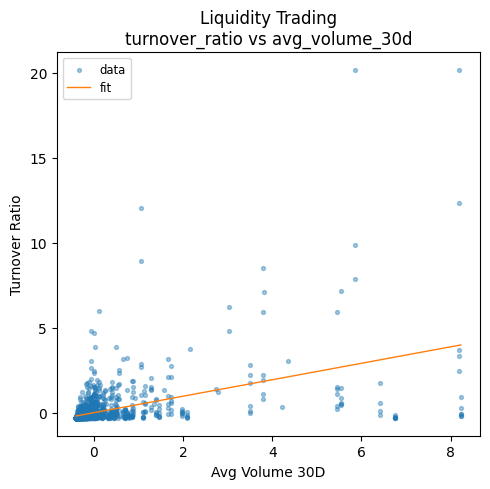

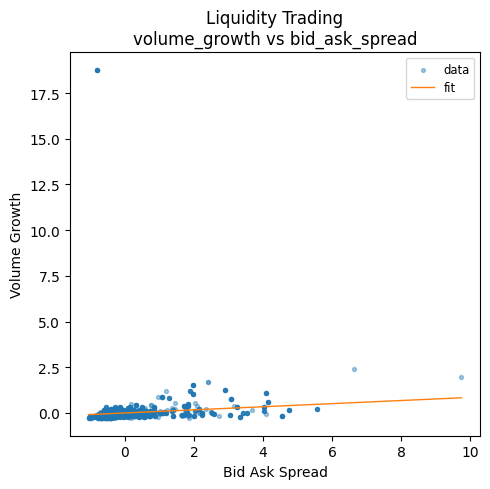

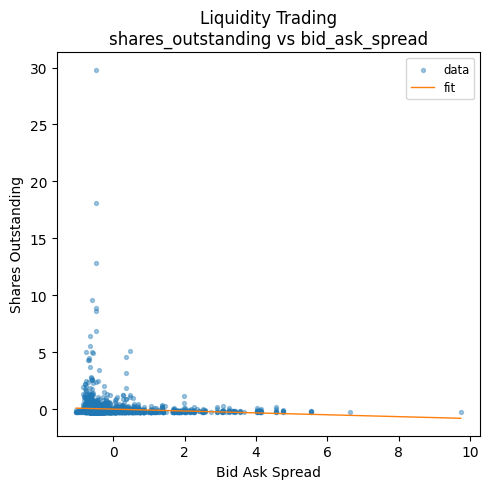

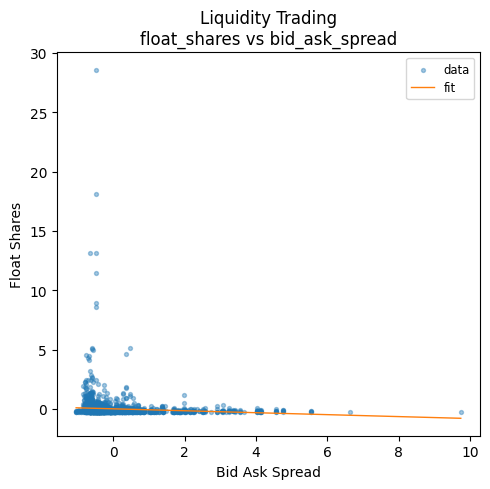

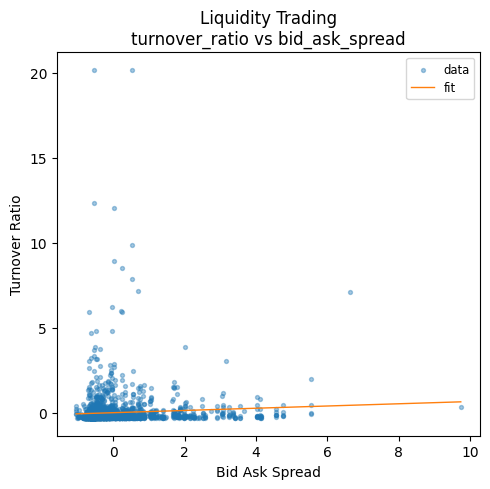

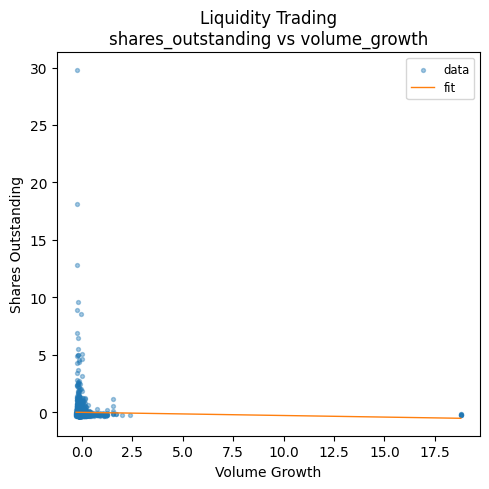

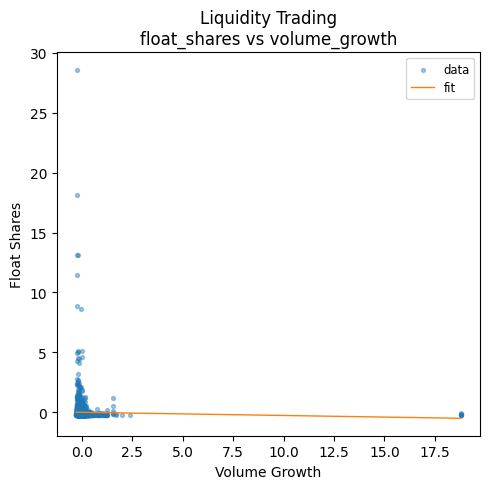

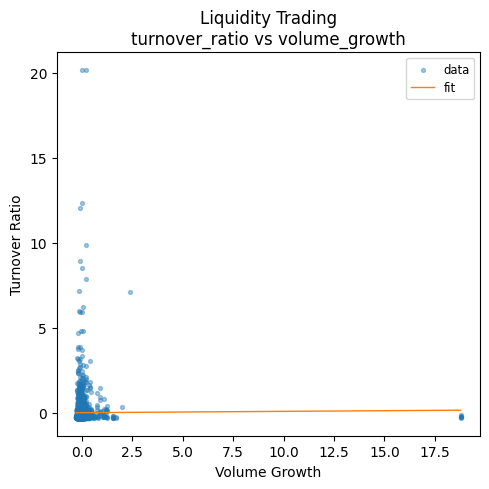

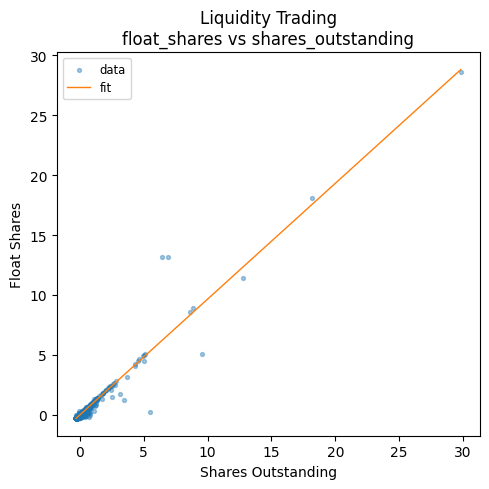

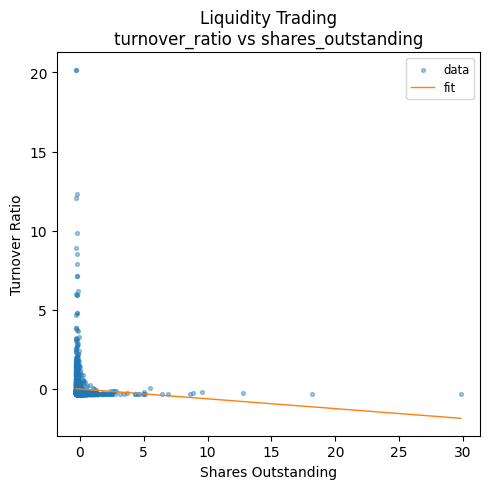

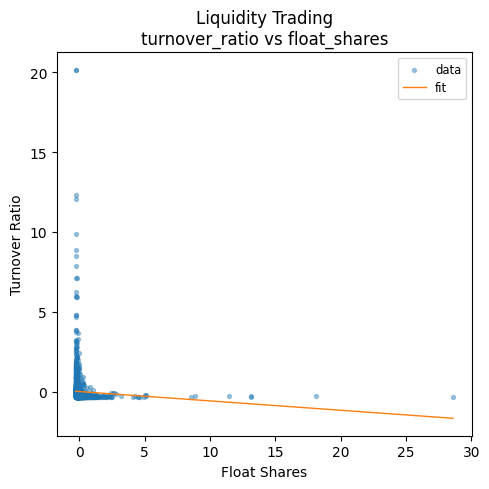

In [4]:
import seaborn as sns
import pandas as pd
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Directories
DATA_DIR = Path("..") / "data" / "processed"
Z_PATH = DATA_DIR / "csiai_input_zscores.parquet"
FIG_DIR = Path("..") / "artifacts" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load z-scored inputs
X_z = pd.read_parquet(Z_PATH)

if "ticker" in X_z.columns:
    X_z = X_z.set_index("ticker")

# Map sub-indices to their columns
groups = {
    "financial_strength": [
        "roe", "debt_to_equity", "current_ratio", "quick_ratio", "oper_cash_flow",
        "total_revenue", "ebitda_margin"
    ],
    "growth_potential": [
        "revenue_growth", "operating_margin", "gross_margin", "rnd_to_revenue",
        "analyst_rating"
    ],
    "market_performance": [
        "pb_ratio", "eps", "market_cap", "ev_to_ebitda",
        "price_to_sales", "payout_ratio"
    ],
    "risk_volatility": [
        "hist_volatility", "beta", "sharpe_ratio", "max_drawdown",
        "stddev_returns", "value_at_risk"
    ],
    "liquidity_trading": [
        "avg_volume_30d", "bid_ask_spread", "volume_growth",
        "shares_outstanding", "float_shares", "turnover_ratio"
    ],
}

# Loop through each group, plot and save
for grp, cols in groups.items():
    for x_col, y_col in itertools.combinations(cols, 2):
        x = X_z[x_col].values
        y = X_z[y_col].values

        # compute 1st-degree fit
        slope, intercept = np.polyfit(x, y, 1)
        line_x = np.linspace(x.min(), x.max(), 100)
        line_y = slope * line_x + intercept

        # plot
        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(x, y, s=8, alpha=0.4, label="data")
        ax.plot(line_x, line_y, color="C1", lw=1, label="fit")
        ax.set_xlabel(x_col.replace("_"," ").title())
        ax.set_ylabel(y_col.replace("_"," ").title())
        ax.set_title(f"{grp.replace('_',' ').title()}\n{y_col} vs {x_col}")
        ax.legend(loc="best", fontsize="small")
        fig.tight_layout()
        plt.show()

        # save
        out_path = FIG_DIR / f"{grp}__{x_col}_vs_{y_col}.png"
        fig.savefig(out_path, dpi=300)
        plt.close(fig)

#### 4.2.1 Financial Strength – ROE vs Other Indicators

- **Debt-to-Equity vs ROE:** Shows almost no linear relationship.  
- **Current Ratio vs ROE:** Slight negative trend more liquidity, marginally lower ROE.  
- **Quick Ratio vs ROE:** Similar to current ratio, a mild inverse relationship.  
- **Operating Cash Flow vs ROE:** Moderate positive association firms with higher cash flow tend to have higher ROE.  
- **Total Revenue vs ROE:** Weak positive slope larger firms slightly more profitable on average.  
- **EBITDA Margin vs ROE:** Strong positive correlation higher margins align with higher ROE.  

#### 4.2.2. Financial Strength – Debt-to-Equity vs Other Indicators

- **Debt-to-Equity vs ROE:** Almost no linear relationship.  
- **Debt-to-Equity vs Current Ratio:** Slight inverse trend higher leverage corresponds to lower short-term liquidity.  
- **Debt-to-Equity vs Quick Ratio:** Mild negative slope, mirroring the current ratio pattern.  
- **Debt-to-Equity vs Operating Cash Flow:** Very weak association cash flow levels do not predict leverage.  
- **Debt-to-Equity vs Total Revenue:** No clear pattern company scale appears uncorrelated with debt ratio.  
- **Debt-to-Equity vs EBITDA Margin:** Small positive slope firms with higher operational profitability tend to carry slightly more debt.  

#### 4.2.3. Financial Strength – Current Ratio vs Other Indicators

- **Debt-to-Equity vs Current Ratio:** Very weak negative relationship more liquid firms tend to carry marginally less leverage.  
- **Quick Ratio vs Current Ratio:** Near-perfect positive linear relationship  as expected since quick ratio is a subset of current ratio.  
- **Operating Cash Flow vs Current Ratio:** Slight negative trend firms with higher short-term liquidity often show modestly lower operating cash generation.  
- **Total Revenue vs Current Ratio:** Liquidity does not reliably indicate company size.  
- **EBITDA Margin vs Current Ratio:** Mild inverse relationship higher liquidity is weakly associated with lower profit margins.  

#### 4.2.4. Financial Strength – Quick Ratio vs Other Indicators

- **Quick Ratio vs ROE:** Slight inverse relationship, suggesting firms with higher quick ratios tend to have marginally lower ROE.  
- **Quick Ratio vs Debt-to-Equity:** Mild negative trend, indicating that more liquid firms carry slightly less gearing.  
- **Quick Ratio vs Current Ratio:** Very strong positive linear association, reflecting the shared underlying liquidity measure.  
- **Quick Ratio vs Operating Cash Flow:** There is no relationship, implying cash flow generation is orthogonal to short-term liquidity.  
- **Quick Ratio vs Total Revenue:** Minimal inverse slope, larger firms show marginally lower quick ratios.  
- **Quick Ratio vs EBITDA Margin:** Slight negative correlation, firms with higher margins tend to carry marginally lower quick ratios.  

#### 4.2.5. Financial Strength – Operating Cash Flow vs Other Indicators

- **Operating Cash Flow vs ROE:** Moderate positive slope companies with higher cash generation tend to have higher returns on equity.  
- **Operating Cash Flow vs Debt-to-Equity:** Near-flat trend leverage levels don’t strongly predict cash-flow strength.  
- **Operating Cash Flow vs Current Ratio:** Very weak relationship short-term liquidity (current ratio) isn’t a reliable proxy for cash generation.  
- **Operating Cash Flow vs Quick Ratio:** Likewise minimal correlation acid-test liquidity and cash flow are largely independent.  
- **Operating Cash Flow vs Total Revenue:** Clear positive association larger revenues usually coincide with stronger operating cash flows.  
- **Operating Cash Flow vs EBITDA Margin:** Mild positive trend firms with higher margins often report healthier cash flows.  

#### 4.2.6. Financial Strength – Total Revenue vs Other Indicators

- **ROE vs Total Revenue:** Weak positive slope I observe that larger firms tend to report slightly higher ROE on average.  
- **Debt-to-Equity vs Total Revenue:** Almost flat relationship firm size has minimal impact on leverage levels in my sample.  
- **Current Ratio vs Total Revenue:** Slightly negative trend as companies grow, their working-capital ratios marginally decrease.  
- **Quick Ratio vs Total Revenue:** Similar to current ratio, a mild inverse association between size and quick liquidity.  
- **Operating Cash Flow vs Total Revenue:** Strong positive correlation firms with higher revenue generate proportionally greater cash flows.  
- **EBITDA Margin vs Total Revenue:** Very modest positive trend larger firms show marginally better operational efficiency.  

#### 4.2.7. Financial Strength – EBITDA Margin vs Other Indicators

- **ROE vs EBITDA Margin:** Clear positive relationship companies with higher EBITDA margins tend to have higher ROE.  
- **Debt-to-Equity vs EBITDA Margin:** Very weak positive slope leverage shows almost no consistent impact on operating efficiency.  
- **Current Ratio vs EBITDA Margin:** Slight negative trend more liquid firms exhibit marginally lower EBITDA margins.  
- **Quick Ratio vs EBITDA Margin:** Similar mild inverse association to current ratio.  
- **Operating Cash Flow vs EBITDA Margin:** Moderate positive correlation firms generating more cash flow often report stronger margins.  
- **Total Revenue vs EBITDA Margin:** Weak positive slope larger firms on average display slightly better EBITDA margins.  

#### 4.2.8. Growth Potential – Revenue Growth vs Other Indicators

- **Operating Margin vs Revenue Growth:** Almost no linear association revenue growth explains very little variation in operating margins.  
- **Gross Margin vs Revenue Growth:** Slight negative trend faster‐growing firms exhibit marginally lower gross margins on average.  
- **R&D to Revenue vs Revenue Growth:** Flat no systematic relationship between R&D intensity and top‐line growth.  
- **Analyst Rating vs Revenue Growth:** Weak negative slope higher growth stocks tend to have marginally lower analyst ratings. 

#### 4.2.9. Growth Potential – Operating Margin vs Other Indicators

- **Operating Margin vs Revenue Growth:** Shows almost no linear relationship, suggesting that revenue changes do not predict operating margin.  
- **Gross Margin vs Operating Margin:** Moderate positive correlation firms with higher gross margins generally exhibit higher operating margins.  
- **R&D-to-Revenue vs Operating Margin:** Strong negative association companies that invest more in R&D (relative to revenue) tend to have lower operating margins.  
- **Analyst Rating vs Operating Margin:** Little to no clear relationship, indicating that ratings are not driven by operating margin levels.  

#### 4.2.10. Growth Potential – Gross Margin vs Other Indicators

- **Gross Margin vs Revenue Growth:** Very weak negative slope suggesting faster‐growing companies do not have higher gross margins.  
- **Gross Margin vs Operating Margin:** Mild positive trend, as firms with higher gross margins tend to convert more of that into operating profit.  
- **Gross Margin vs R&D to Revenue:** Flat, indicating R&D has little direct relation to gross margin levels.  
- **Gross Margin vs Analyst Rating:** No linear association, implying analyst ratings are not driven by gross margin differences.  

#### 4.2.11 Growth Potential – R&D / Revenue vs Other Indicators

- **Revenue Growth vs R&D / Revenue:** Almost no relationship companies with higher R&D intensity do not necessarily grow faster.  
- **Operating Margin vs R&D / Revenue:** Strong negative trend as R&D share rises, current margins tend to be lower which might be a sign of reinvestment.  
- **Gross Margin vs R&D / Revenue:** Slight negative slope higher R&D intensity often accompanies thinner gross margins.  
- **Analyst Rating vs R&D / Revenue:** No clear pattern analyst rating does not vary meaningfully with R&D intensity.  

#### 4.2.12. Growth Potential – Analyst Rating vs Other Indicators

- **Analyst Rating vs Revenue Growth:** Almost no trend analyst ratings have no relation to past revenue growth.  
- **Analyst Rating vs Operating Margin:** Flat relationship operating profitability doesn’t map to analyst ratings.
- **Analyst Rating vs Gross Margin:** No systematic link firms with higher gross margins are neither consistently more nor less favorably rated.
- **Analyst Rating vs R&D-to-Revenue:** Near zero slope R&D intensity has negligible impact on  analyst scores.  

#### 4.2.13 Market Performance – PB Ratio vs Other Indicators

- **EPS vs PB Ratio:** Essentially flat relationship share valuation does not track earnings per share.  
- **Market Cap vs PB Ratio:** Slight positive slope larger firms tend to trade at marginally higher price-to-book ratios.  
- **EV/EBITDA vs PB Ratio:** No meaningful trend enterprise multiples are independent of book-value multiples.  
- **Price-to-Sales vs PB Ratio:** Almost zero slope revenue multiples and book multiples move independently in this.  
- **Payout Ratio vs PB Ratio:** Higher dividend payout may be linked to slightly lower valuation multiples.  

#### 4.2.14. Market Performance – EPS vs Other Indicators

- **PB Ratio vs EPS:** Almost flat relationship EPS does not meaningfully explain variations in price-to-book multiples.  
- **Market Cap vs EPS:** Mild positive trend firms with higher EPS tend to have slightly larger market capitalizations.  
- **EV/EBITDA vs EPS:** No clear pattern enterprise valuation multiples appear independent of EPS.  
- **Price-to-Sales vs EPS:** No slope sales multiples are not driven by EPS levels.  
- **Payout Ratio vs EPS:** Slight negative association companies with higher EPS pay out a marginally smaller proportion of earnings.  

#### 4.2.15. Market Performance – Market Cap vs Other Indicators
- **PB Ratio vs Market Cap:** Weak positive slope larger firms tend to have slightly higher price-to-book ratios.
- **EPS vs Market Cap:** Mild positive trend larger firms tend to report higher EPS.
- **EV/EBITDA vs Market Cap:** No clear relationship enterprise multiples do not correlate with market capitalization.
- **Price-to-Sales vs Market Cap:** No slope sales multiples are not driven by market capitalization.
- **Payout Ratio vs Market Cap:** No clear pattern larger firms do not necessarily have higher or lower payout ratios.

#### 4.2.16 Market Performance – EV/EBITDA vs Other Indicators

- **PB Ratio vs EV/EBITDA:** Very flat relationship with a slight downward tilt at higher EV/EBITDA values, indicating little correlation.  
- **EPS vs EV/EBITDA:** No slope, showing that earnings per share do not explain enterprise multiples.  
- **Market Cap vs EV/EBITDA:** Nearly horizontal line, suggesting market capitalization is independent of EV/EBITDA.  
- **Price-to-Sales vs EV/EBITDA:** Mostly flat but with a mild downward trend at the right tail, implying weak inverse association.  
- **Payout Ratio vs EV/EBITDA:** Almost perfectly flat, indicating no relationship between payout policy and enterprise valuation multiples.  

#### 4.2.17 Market Performance – Price-to-Sales vs Other Indicators

- **PB Ratio vs Price-to-Sales:** Largely flat with a gentle downward curve at high P/S values indicating a weak inverse relationship.  
- **EPS vs Price-to-Sales:** Almost horizontal but bending slightly downward on the right suggesting minimal negative association.  
- **Market Cap vs Price-to-Sales:** Straight trend with a mild downward tilt as P/S increases showing little correlation.  
- **EV/EBITDA vs Price-to-Sales:** Nearly flat overall, with a small negative slope on the tail implying a slight inverse link.  
- **Price-to-Sales vs Payout Ratio:** Mostly level but bending down at higher P/S denoting a negligible negative relationship.  

#### 4.2.18 Market Performance – Payout Ratio vs Other Indicators

- **PB Ratio vs Payout Ratio:** Essentially flat indicating no clear relationship.  
- **EPS vs Payout Ratio:** Slight downward bend on the right suggesting a minimal negative association.  
- **Market Cap vs Payout Ratio:** Nearly straight with a modest downward curve at high payout ratios implying a weak inverse link.  
- **EV/EBITDA vs Payout Ratio:** Straight horizontal trend showing no apparent correlation.  
- **Price-to-Sales vs Payout Ratio:** Mostly flat but dipping slightly at the right tail indicating a negligible negative trend.  

#### 4.2.19 Risk & Volatility – Historical Volatility vs Other Indicators

- **Historical Volatility vs Beta:** Slight positive slope indicating more volatile assets tend to have marginally higher beta.  
- **Historical Volatility vs Sharpe Ratio:** Strong negative correlation as volatility increases, risk‐adjusted returns decline.  
- **Historical Volatility vs Max Drawdown:** Nearly perfect negative slope  higher volatility corresponds to deeper drawdowns.  
- **Historical Volatility vs Std Dev Returns:** Almost perfect positive slope showing that more volatile assets have higher return dispersion.  
- **Historical Volatility vs Value at Risk:** Almost perfect positive trend suggesting higher volatility leads to higher estimated losses.  

#### 4.2.20 Risk & Volatility – Beta vs Other Indicators

- **Beta vs Historical Volatility:** Slight positive trend as assets with higher beta tend to be more volatile.  
- **Beta vs Sharpe Ratio:** Nearly flat with a mild negative slope indicating higher beta lightly erodes risk‐adjusted returns.  
- **Beta vs Max Drawdown:** Strong positive association assets more sensitive to market moves suffer larger drawdowns.  
- **Beta vs Std Dev Returns:** Good positive correlation reflecting that higher market sensitivity comes with greater return variability.  
- **Beta vs Value at Risk:** Mild positive slope showing a small increase in expected losses with higher beta.  

#### 4.2.21 Risk & Volatility – Sharpe Ratio vs Other Indicators

- **Sharpe Ratio vs Beta:** Almost flat with a slight negative tilt indicating higher market sensitivity modestly lowers risk‐adjusted returns.  
- **Sharpe Ratio vs Historical Volatility:** Strong negative correlation more volatility leads to lower risk‐adjusted performance.  
- **Sharpe Ratio vs Max Drawdown:** Positive correlation suggesting assets with better risk‐adjusted returns experience smaller drawdowns.  
- **Sharpe Ratio vs Std Dev Returns:** Negative correlation as higher dispersion of returns reduces risk‐adjusted performance.  
- **Sharpe Ratio vs Value at Risk:** Very negative relationship higher expected losses correspond to poorer risk‐adjusted returns.  

#### 4.2.22 Risk & Volatility – Max Drawdown vs Other Indicators

- **Max Drawdown vs Beta:** Strong positive relationship assets with higher market sensitivity endure deeper drawdowns.  
- **Max Drawdown vs Historical Volatility:** Nearly perfect negative slope (drawdown is negative), indicating more volatile assets suffer larger losses.  
- **Max Drawdown vs Sharpe Ratio:** Positive correlation, since assets with better risk‐adjusted returns have smaller drawdowns.  
- **Max Drawdown vs Std Dev Returns:** Strong negative correlation showing that larger return variability is linked to deeper drawdowns.  
- **Max Drawdown vs Value at Risk:** Strong negative association as assets with deeper drawdowns also exhibit higher estimated losses.  

#### 4.2.23 Risk & Volatility – Std Dev Returns vs Other Indicators

- **Std Dev Returns vs Beta:** Good positive correlation, indicating market‐sensitive assets show greater return dispersion.  
- **Std Dev Returns vs Historical Volatility:** Nearly perfect positive slope reflecting that standard deviation of returns and volatility move together.  
- **Std Dev Returns vs Sharpe Ratio:** Negative correlation as higher dispersion lowers risk‐adjusted returns.  
- **Std Dev Returns vs Max Drawdown:** Strong negative relationship linking greater return variability to deeper drawdowns.  
- **Std Dev Returns vs Value at Risk:** Very strong positive correlation showing that assets with larger return swings face higher VaR.  

#### 4.2.24 Risk & Volatility – Value at Risk vs Other Indicators

- **Value at Risk vs Beta:** Mild positive slope, indicating higher market sensitivity slightly increases estimated losses.  
- **Value at Risk vs Historical Volatility:** Near‐perfect positive trend, showing VaR rises in tandem with volatility.  
- **Value at Risk vs Sharpe Ratio:** Very negative correlation, as assets with higher expected losses deliver poorer risk‐adjusted returns.  
- **Value at Risk vs Max Drawdown:** Strong negative association, linking larger drawdowns to higher VaR.  
- **Value at Risk vs Std Dev Returns:** Very strong positive correlation, reflecting that greater return variability escalates estimated losses.  

#### 4.2.25 Liquidity & Trading – 30-Day Average Volume vs Other Indicators

- **30-Day Avg Volume vs Bid-Ask Spread:** Nearly flat overall with a slight downward bend at the high volume end.  
- **30-Day Avg Volume vs Volume Growth:** Mostly flat relationship with a tiny downward bend in the highest volume stocks.  
- **30-Day Avg Volume vs Shares Outstanding:** Clear positive correlation larger share counts tend to have higher trading volumes.  
- **30-Day Avg Volume vs Float Shares:** Strong positive association stocks with more freely traded shares see higher volumes.  
- **30-Day Avg Volume vs Turnover Ratio:** Good positive correlation higher volume generally means higher turnover relative to float.  

#### 4.2.26 Liquidity & Trading – Bid-Ask Spread vs Other Indicators

- **Bid-Ask Spread vs 30-Day Avg Volume:** Almost flat  but narrows slightly in very high-volume stocks.  
- **Bid-Ask Spread vs Volume Growth:** Mildly positive slope stocks whose volumes are rising tend to have slightly wider spreads.  
- **Bid-Ask Spread vs Shares Outstanding:** Mild negative trend stocks with more shares outstanding generally have tighter spreads.  
- **Bid-Ask Spread vs Float Shares:** Mild negative slope higher free float is associated with narrower spreads.  
- **Bid-Ask Spread vs Turnover Ratio:** Mild positive correlation higher turnover stocks can exhibit marginally wider spreads.  

#### 4.2.27 Liquidity & Trading – Volume Growth vs Other Indicators

- **Volume Growth vs 30-Day Avg Volume:** Largely flat, with a very slight downward bend at the highest volumes.  
- **Volume Growth vs Bid-Ask Spread:** Mild positive slope stocks with growing volumes have slightly wider spreads.  
- **Volume Growth vs Shares Outstanding:** Mild negative relationship larger share counts often see lower volume growth rates.  
- **Volume Growth vs Float Shares:** Mild negative slope stocks with larger float tend to have more stable (less growing) volumes.  
- **Volume Growth vs Turnover Ratio:** Almost flat relationship turnover changes little with shifts in volume growth.  

#### 4.2.28 Liquidity & Trading – Shares Outstanding vs Other Indicators

- **Shares Outstanding vs 30-Day Avg Volume:** Strong positive correlation companies with more shares outstanding trade more volume.  
- **Shares Outstanding vs Bid-Ask Spread:** Mild negative slope greater share counts generally coincide with tighter spreads.  
- **Shares Outstanding vs Volume Growth:** Mild negative relationship larger share bases see slightly less volume growth.  
- **Shares Outstanding vs Float Shares:** Very strong positive correlation the public float is closely tied to total shares outstanding.  
- **Shares Outstanding vs Turnover Ratio:** Clear negative correlation firms with more shares outstanding have lower turnover percentages.  

#### 4.2.29 Liquidity & Trading – Float Shares vs Other Indicators

- **Float Shares vs 30-Day Avg Volume:** Strong positive association more freely tradable shares lead to higher volumes.  
- **Float Shares vs Bid-Ask Spread:** Mild negative slope larger floats have tighter spreads.  
- **Float Shares vs Volume Growth:** Mild negative relationship stocks with bigger floats have slightly lower volume growth.  
- **Float Shares vs Shares Outstanding:** Very strong positive correlation float closely tracks total shares outstanding.  
- **Float Shares vs Turnover Ratio:** Noticeable negative correlation higher float stocks see lower turnover percentages.  

#### 4.2.30 Liquidity & Trading – Turnover Ratio vs Other Indicators

- **Turnover Ratio vs 30-Day Avg Volume:** Good positive correlation higher turnover is linked with greater trading volumes.  
- **Turnover Ratio vs Bid-Ask Spread:** Mild positive slope stocks that trade more relative to float have slightly wider spreads.  
- **Turnover Ratio vs Volume Growth:** Nearly flat turnover ratio remains stable regardless of volume growth.  
- **Turnover Ratio vs Shares Outstanding:** Clear negative relationship more shares outstanding leads to lower turnover ratios.  
- **Turnover Ratio vs Float Shares:** Negative correlation larger floats correspond to lower turnover as a percentage of float.  

## 4.3. Correlation Analysis

In this section I compute Pearson correlation matrices for each of the five sub-indices—and one for the full indicator set to explore the strength and direction of pairwise relationships.

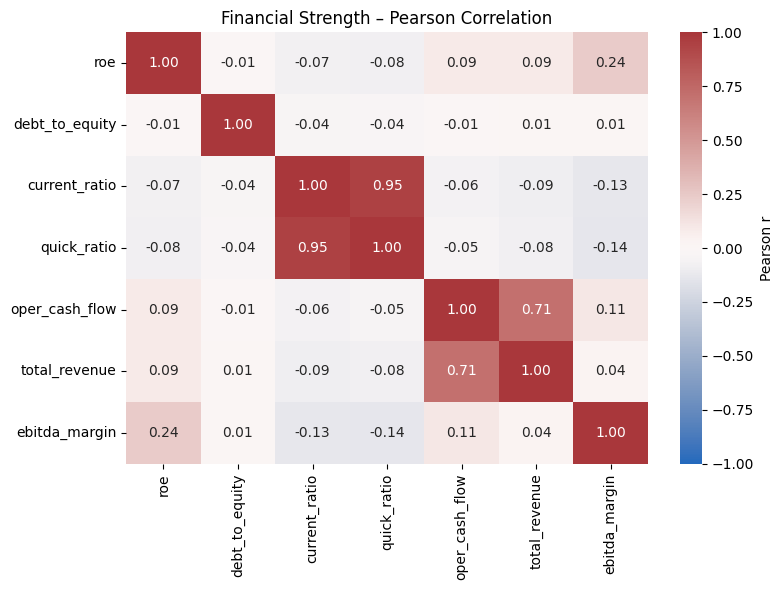


>> Financial Strength correlation matrix:



,roe,debt_to_equity,current_ratio,quick_ratio,oper_cash_flow,total_revenue,ebitda_margin
roe,1.00,-0.01,-0.07,-0.08,0.09,0.09,0.24
debt_to_equity,-0.01,1.00,-0.04,-0.04,-0.01,0.01,0.01
current_ratio,-0.07,-0.04,1.00,0.95,-0.06,-0.09,-0.13
quick_ratio,-0.08,-0.04,0.95,1.00,-0.05,-0.08,-0.14
oper_cash_flow,0.09,-0.01,-0.06,-0.05,1.00,0.71,0.11
total_revenue,0.09,0.01,-0.09,-0.08,0.71,1.00,0.04
ebitda_margin,0.24,0.01,-0.13,-0.14,0.11,0.04,1.00


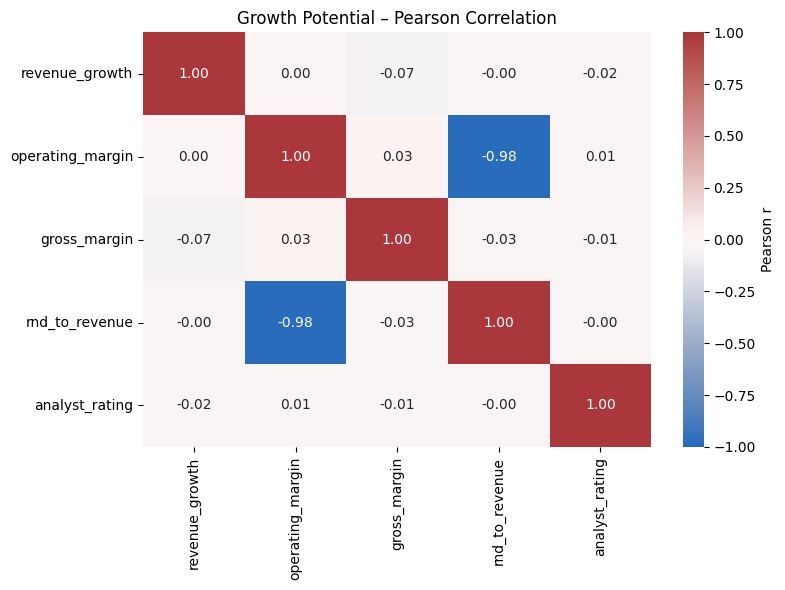


>> Growth Potential correlation matrix:



,revenue_growth,operating_margin,gross_margin,rnd_to_revenue,analyst_rating
revenue_growth,1.00,0.00,-0.07,-0.00,-0.02
operating_margin,0.00,1.00,0.03,-0.98,0.01
gross_margin,-0.07,0.03,1.00,-0.03,-0.01
rnd_to_revenue,-0.00,-0.98,-0.03,1.00,-0.00
analyst_rating,-0.02,0.01,-0.01,-0.00,1.00


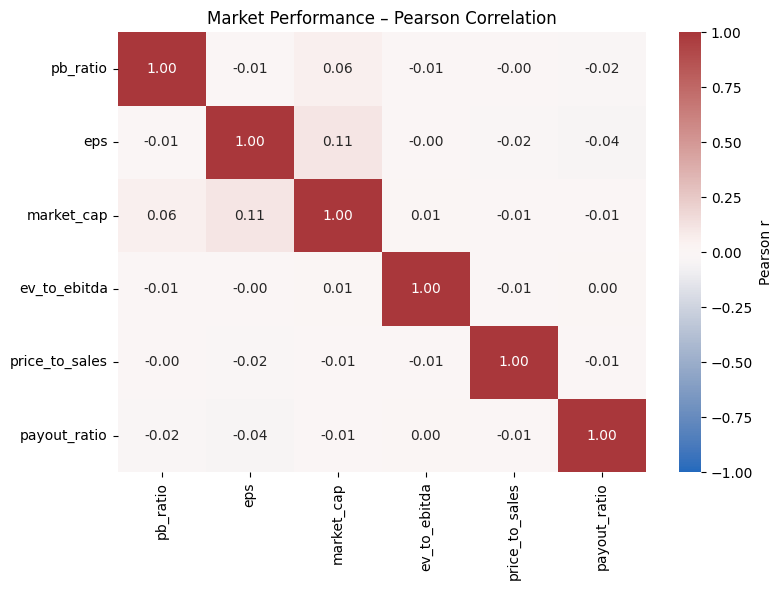


>> Market Performance correlation matrix:



,pb_ratio,eps,market_cap,ev_to_ebitda,price_to_sales,payout_ratio
pb_ratio,1.00,-0.01,0.06,-0.01,-0.00,-0.02
eps,-0.01,1.00,0.11,-0.00,-0.02,-0.04
market_cap,0.06,0.11,1.00,0.01,-0.01,-0.01
ev_to_ebitda,-0.01,-0.00,0.01,1.00,-0.01,0.00
price_to_sales,-0.00,-0.02,-0.01,-0.01,1.00,-0.01
payout_ratio,-0.02,-0.04,-0.01,0.00,-0.01,1.00


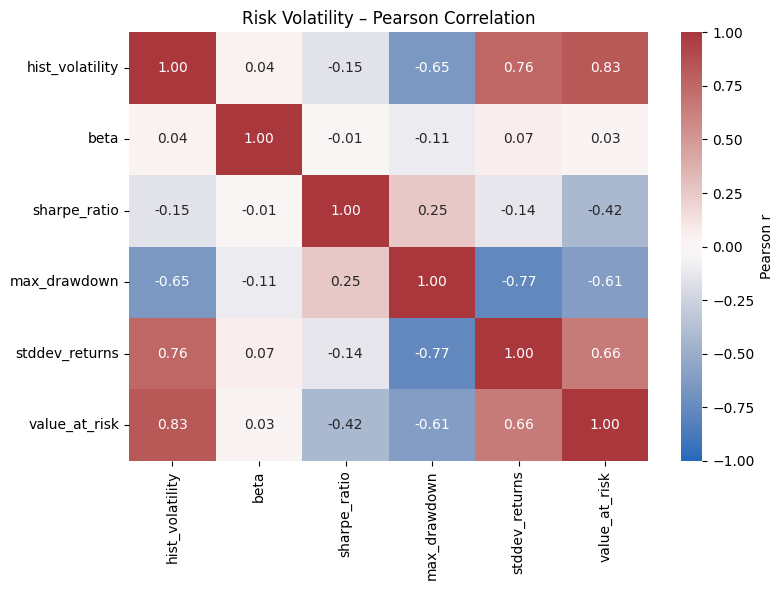


>> Risk Volatility correlation matrix:



,hist_volatility,beta,sharpe_ratio,max_drawdown,stddev_returns,value_at_risk
hist_volatility,1.00,0.04,-0.15,-0.65,0.76,0.83
beta,0.04,1.00,-0.01,-0.11,0.07,0.03
sharpe_ratio,-0.15,-0.01,1.00,0.25,-0.14,-0.42
max_drawdown,-0.65,-0.11,0.25,1.00,-0.77,-0.61
stddev_returns,0.76,0.07,-0.14,-0.77,1.00,0.66
value_at_risk,0.83,0.03,-0.42,-0.61,0.66,1.00


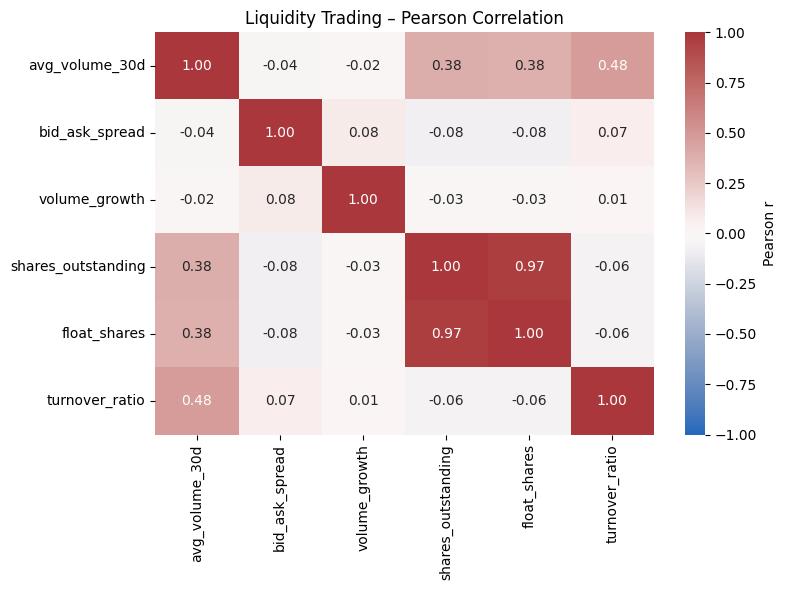


>> Liquidity Trading correlation matrix:



,avg_volume_30d,bid_ask_spread,volume_growth,shares_outstanding,float_shares,turnover_ratio
avg_volume_30d,1.00,-0.04,-0.02,0.38,0.38,0.48
bid_ask_spread,-0.04,1.00,0.08,-0.08,-0.08,0.07
volume_growth,-0.02,0.08,1.00,-0.03,-0.03,0.01
shares_outstanding,0.38,-0.08,-0.03,1.00,0.97,-0.06
float_shares,0.38,-0.08,-0.03,0.97,1.00,-0.06
turnover_ratio,0.48,0.07,0.01,-0.06,-0.06,1.00



>> Global correlation matrix (all indicators):



,roe,debt_to_equity,current_ratio,quick_ratio,oper_cash_flow,total_revenue,ebitda_margin,revenue_growth,operating_margin,gross_margin,...,sharpe_ratio,max_drawdown,stddev_returns,value_at_risk,avg_volume_30d,bid_ask_spread,volume_growth,shares_outstanding,float_shares,turnover_ratio
roe,1.00,-0.01,-0.07,-0.08,0.09,0.09,0.24,-0.02,0.02,0.07,...,0.10,0.14,-0.11,-0.08,0.07,-0.09,-0.02,0.06,0.06,0.02
debt_to_equity,-0.01,1.00,-0.04,-0.04,-0.01,0.01,0.01,-0.01,0.01,0.01,...,-0.01,0.02,-0.01,-0.01,-0.03,0.01,0.05,-0.01,-0.01,-0.02
current_ratio,-0.07,-0.04,1.00,0.95,-0.06,-0.09,-0.13,0.05,-0.07,0.01,...,-0.03,-0.12,0.14,0.04,-0.04,0.08,0.05,-0.04,-0.04,0.01
quick_ratio,-0.08,-0.04,0.95,1.00,-0.05,-0.08,-0.14,0.05,-0.08,0.03,...,-0.04,-0.11,0.13,0.04,-0.04,0.08,0.06,-0.03,-0.03,-0.00
oper_cash_flow,0.09,-0.01,-0.06,-0.05,1.00,0.71,0.11,-0.01,0.01,0.05,...,0.02,0.13,-0.10,-0.05,0.44,-0.09,-0.03,0.71,0.78,-0.03
total_revenue,0.09,0.01,-0.09,-0.08,0.71,1.00,0.04,-0.01,0.01,-0.07,...,0.03,0.14,-0.12,-0.04,0.40,-0.10,-0.03,0.57,0.57,-0.03
ebitda_margin,0.24,0.01,-0.13,-0.14,0.11,0.04,1.00,-0.16,0.01,0.34,...,0.05,0.20,-0.16,-0.12,0.08,-0.19,-0.01,0.08,0.08,-0.00
revenue_growth,-0.02,-0.01,0.05,0.05,-0.01,-0.01,-0.16,1.00,0.00,-0.07,...,0.03,0.02,-0.01,-0.01,-0.01,0.01,0.00,0.01,0.01,-0.01
operating_margin,0.02,0.01,-0.07,-0.08,0.01,0.01,0.01,0.00,1.00,0.03,...,0.03,0.04,-0.01,-0.03,0.01,-0.03,-0.00,0.00,0.01,0.01
gross_margin,0.07,0.01,0.01,0.03,0.05,-0.07,0.34,-0.07,0.03,1.00,...,0.05,0.09,-0.05,-0.05,0.07,-0.06,-0.02,0.04,0.04,-0.01


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

ROOT      = Path("..")
DATA_DIR  = ROOT / "data" / "processed"
Z_PATH    = DATA_DIR / "csiai_input_zscores.parquet"

HEAT_DIR  = ROOT / "artifacts" / "figures" / "correlations"
HEAT_DIR.mkdir(parents=True, exist_ok=True)

X_z = pd.read_parquet(Z_PATH)
if "ticker" in X_z.columns:
    X_z = X_z.set_index("ticker")

groups = {
    "financial_strength": [
        "roe","debt_to_equity","current_ratio","quick_ratio","oper_cash_flow",
        "total_revenue","ebitda_margin"
    ],
    "growth_potential": [
        "revenue_growth","operating_margin","gross_margin","rnd_to_revenue",
        "analyst_rating"
    ],
    "market_performance": [
        "pb_ratio","eps","market_cap","ev_to_ebitda",
        "price_to_sales","payout_ratio"
    ],
    "risk_volatility": [
        "hist_volatility","beta","sharpe_ratio","max_drawdown",
        "stddev_returns","value_at_risk"
    ],
    "liquidity_trading": [
        "avg_volume_30d","bid_ask_spread","volume_growth",
        "shares_outstanding","float_shares","turnover_ratio"
    ],
}

# method for plotting and printing
def show_corr(group_name, cols, df):
    # compute Pearson r
    corr = df[cols].corr(method="pearson")
    # plot heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", vmin=-1, vmax=1,
                cbar_kws={"label":"Pearson r"})
    plt.title(f"{group_name.replace('_',' ').title()} – Pearson Correlation")
    plt.tight_layout()
    plt.savefig(HEAT_DIR / f"heatmap_{group_name}.png", dpi=300)
    plt.show()
    # print table
    print(f"\n>> {group_name.replace('_',' ').title()} correlation matrix:\n")
    display(corr.round(2))

# now loop through each group
for grp, cols in groups.items():
    df_grp = X_z[cols].dropna(how="any")
    show_corr(grp, cols, df_grp)

# now to do for all variables
all_cols = X_z.columns.tolist()
df_all   = X_z[all_cols].dropna(how="any")
corr_all = df_all.corr(method="pearson")
print("\n>> Global correlation matrix (all indicators):\n")
display(corr_all.round(2))

#### 4.3.1 Financial Strength – Key correlations

- **Current Ratio and Quick Ratio (r = 0.95):** Near‐perfect collinearity both measure short-term liquidity.  
- **Operating Cash Flow and Total Revenue (r = 0.71):** Strong positive link larger revenues tend to generate more cash.  
- **EBITDA Margin and ROE (r = 0.24):** Moderate positive relation  higher margins often translate into better returns on equity.  
- All other pairwise correlations are weak (|r| < 0.15), suggesting these indicators largely capture distinct aspects of financial strength.  

---

#### 4.3.2 Growth Potential – Key correlations

- **Operating Margin and R&D-to-Revenue (r = –0.98):** Almost perfect inverse relationship firms investing heavily in R&D tend to report lower operating margins in the same period.  
- All other pairs in this group exhibit negligible correlations (|r| < 0.10), indicating broad independence among growth‐potential metrics.  

---

#### 4.3.3 Market Performance – Key correlations

- **EPS and Market Cap (r = 0.11):** Small positive link larger companies tend to report slightly higher earnings per share.  
- All remaining correlations fall below |r| = 0.10, implying valuation ratios and payout metrics offer largely orthogonal information.  

---

#### 4.3.4 Risk & Volatility – Key correlations

- **Value at Risk and Historical Volatility (r = 0.83):** Very strong positive association more volatile stocks face higher downside risk.  
- **Value at Risk and Std Dev Returns (r = 0.66):** Strong positive link stocks with dispersed returns also have larger tail losses.  
- **Std Dev Returns and Historical Volatility (r = 0.76):** High concordance both capture spread of returns.  
- **Max Drawdown and Std Dev Returns (r = –0.77):** Strong inverse relation greater variability correlates with deeper declines.  
- **Max Drawdown and Historical Volatility (r = –0.65):** Substantial negative slope high volatility stocks suffer larger drawdowns.  
- **Sharpe Ratio correlates weakly with all others (|r| < 0.25), reflecting its distinct risk-adjusted viewpoint.**  

---

#### 4.3.5 Liquidity & Trading – Key correlations

- **Float Shares and Shares Outstanding (r = 0.97):** Almost perfect collinearity float is just a subset of total shares.  
- **Turnover Ratio and Avg 30-day Volume (r = 0.48):** Moderate positive relation stocks traded in high volume also have higher turnover relative to float.  
- All other pairwise links are weak (|r| < 0.40), indicating liquidity depth, trading activity, and spreads each add unique information.  

## 4.4. Factorability Diagnostics: KMO & Bartlett’s Tests

In this section, I assess whether my 30‐indicator dataset is suitable for Principal Component Analysis. Following the recommendations in the **Handbook on Constructing Composite Indicators: Methodology and User Guide**, I will compute:

- **Kaiser–Meyer–Olkin (KMO) measure of sampling adequacy**  
  - Evaluates the proportion of variance among variables that might be common variance.  
  - A KMO overall value ≥ 0.60 is generally considered acceptable for factor analysis.  
- **Bartlett’s test of sphericity**  
  - Tests the null hypothesis that the correlation matrix is an identity matrix - to make sure that the variables are correlated enough to justify factor analysis.  
  - A significant p‐value (p < 0.05) indicates that correlations are large enough to justify factor analysis.

In [8]:
import pandas as pd
from pathlib import Path
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

ROOT       = Path("..")
DATA_DIR   = ROOT / "data" / "processed"
Z_PATH     = DATA_DIR / "csiai_input_zscores.parquet"
ARTIFACTS_DIR = ROOT / "artifacts"
OUT_CSV    = ARTIFACTS_DIR / "diagnostics_factorability.csv"

df = pd.read_parquet(Z_PATH)
if "ticker" in df.columns:
    df = df.set_index("ticker")

groups = {
    "financial_strength": [
        "roe","debt_to_equity","current_ratio","quick_ratio","oper_cash_flow",
        "total_revenue","ebitda_margin"
    ],
    "growth_potential": [
        "revenue_growth","operating_margin","gross_margin","rnd_to_revenue",
        "analyst_rating"
    ],
    "market_performance": [
        "pb_ratio","eps","market_cap","ev_to_ebitda",
        "price_to_sales","payout_ratio"
    ],
    "risk_volatility": [
        "hist_volatility","beta","sharpe_ratio","max_drawdown",
        "stddev_returns","value_at_risk"
    ],
    "liquidity_trading": [
        "avg_volume_30d","bid_ask_spread","volume_growth",
        "shares_outstanding","float_shares","turnover_ratio"
    ],
}

results = []

# for all variables
chi2_g, p_g = calculate_bartlett_sphericity(df)
kmo_per_g, kmo_all_g   = calculate_kmo(df)
results.append({
    "group":             "global",
    "kmo_overall":       round(kmo_all_g, 3),
    "bartlett_chi2":     round(chi2_g, 2),
    "bartlett_p_value":  round(p_g, 4)
})

# for each group
for grp, cols in groups.items():
    sub = df[cols].dropna(axis=0, how="any")
    chi2, p   = calculate_bartlett_sphericity(sub)
    kmo_per, kmo_all  = calculate_kmo(sub)
    results.append({
        "group":             grp,
        "kmo_overall":       round(kmo_all, 3),
        "bartlett_chi2":     round(chi2, 2),
        "bartlett_p_value":  round(p, 4)
    })

df_res = pd.DataFrame(results)
df_res.to_csv(OUT_CSV, index=False)
print(f"Factorability diagnostics written to {OUT_CSV}")

display(df_res)

Factorability diagnostics written to ../artifacts/diagnostics_factorability.csv


/Users/patrick/Documents/Final year/csiai-project/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/patrick/Documents/Final year/csiai-project/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/patrick/Documents/Final year/csiai-project/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/patrick/Documents/Final year/csiai-project/venv/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


,group,kmo_overall,bartlett_chi2,bartlett_p_value
0,global,0.688,40366.65,0.0000
1,financial_strength,0.513,7074.78,0.0000
2,growth_potential,0.500,7205.07,0.0000
3,market_performance,0.496,43.19,0.0001
4,risk_volatility,0.710,7533.68,0.0000
5,liquidity_trading,0.544,7262.17,0.0000


### 4.4.1 KMO & Bartlett’s Test – Summary of Factorability

| Group                   | KMO overall | Bartlett’s χ² | p-value | Adequacy      |
|-------------------------|------------:|-------------:|--------:|---------------|
| **Global**              | 0.688       | 40 366.65    | <.001   | Good (≥0.60)  |
| **Financial Strength**  | 0.513       |  7 074.78    | <.001   | Marginal (~0.50) |
| **Growth Potential**    | 0.500       |  7 205.07    | <.001   | Borderline (≈0.50) |
| **Market Performance**  | 0.496       |     43.19    | <.001   | Poor (<0.50)  |
| **Risk & Volatility**   | 0.710       |  7 533.68    | <.001   | Good (>0.70)  |
| **Liquidity & Trading** | 0.544       |  7 262.17    | <.001   | Marginal (~0.54) |

**Key points:**
- **Bartlett’s test** is highly significant (p < .001) across **all** groups: the correlation matrices are not identity, so factor/PCA is justified.
- **KMO ≥ 0.60** (Global, Risk & Volatility) indicates **adequate sampling** for reliable factor extraction.
- **KMO ≈ 0.50–0.60** (Financial Strength, Growth Potential, Liquidity & Trading) suggests **marginal factorability** we may need to revisit or combine weaker items.
- **KMO < 0.50** (Market Performance) signals **poor factorability** this sub-index likely requires dropping or redefining variables before further multivariate analysis.

> “KMO values ≥ 0.60 are acceptable for PCA/FA; values < 0.60 warn against extracting stable factors.”

In [10]:
import pandas as pd
from pathlib import Path
from factor_analyzer.factor_analyzer import calculate_kmo

ROOT       = Path("..")
DATA_DIR   = ROOT / "data" / "processed"
Z_PATH     = DATA_DIR / "csiai_input_zscores.parquet"

# Load z-scored, complete inputs
X_z = pd.read_parquet(Z_PATH)
if "ticker" in X_z.columns:
    X_z = X_z.set_index("ticker")

groups = {
    "financial_strength": [
        "roe","debt_to_equity","current_ratio","quick_ratio","oper_cash_flow",
        "total_revenue","ebitda_margin"
    ],
    "growth_potential": [
        "revenue_growth","operating_margin","gross_margin","rnd_to_revenue",
        "analyst_rating"
    ],
    "market_performance": [
        "pb_ratio","eps","market_cap","ev_to_ebitda",
        "price_to_sales","payout_ratio"
    ],
    "risk_volatility": [
        "hist_volatility","beta","sharpe_ratio","max_drawdown",
        "stddev_returns","value_at_risk"
    ],
    "liquidity_trading": [
        "avg_volume_30d","bid_ask_spread","volume_growth",
        "shares_outstanding","float_shares","turnover_ratio"
    ],
}

# now for the individual KMO
for grp, cols in groups.items():
    df_grp = X_z[cols].dropna(how="any")
    
    # calculate KMO
    kmo_all, kmo_model = calculate_kmo(df_grp)
    
    df_kmo = pd.DataFrame({
        "variable": cols,
        "kmo_individual": kmo_all
    }).set_index("variable").sort_values("kmo_individual")
    
    print(f"\n Sub-index: {grp.replace('_',' ').title()}")
    print(f"  • Overall KMO: {kmo_model:.3f}")
    display(df_kmo)

    # Pearson correlation matrix
    corr = df_grp.corr(method="pearson")
    print(f"- Pearson Correlation Matrix ({grp.replace('_',' ').title()}):")
    display(corr.round(2))


 Sub-index: Financial Strength
  • Overall KMO: 0.513


,kmo_individual
variable,
oper_cash_flow,0.506505
total_revenue,0.508245
quick_ratio,0.509030
current_ratio,0.509512
ebitda_margin,0.595491
roe,0.603131
debt_to_equity,0.713863


- Pearson Correlation Matrix (Financial Strength):


,roe,debt_to_equity,current_ratio,quick_ratio,oper_cash_flow,total_revenue,ebitda_margin
roe,1.00,-0.01,-0.07,-0.08,0.09,0.09,0.24
debt_to_equity,-0.01,1.00,-0.04,-0.04,-0.01,0.01,0.01
current_ratio,-0.07,-0.04,1.00,0.95,-0.06,-0.09,-0.13
quick_ratio,-0.08,-0.04,0.95,1.00,-0.05,-0.08,-0.14
oper_cash_flow,0.09,-0.01,-0.06,-0.05,1.00,0.71,0.11
total_revenue,0.09,0.01,-0.09,-0.08,0.71,1.00,0.04
ebitda_margin,0.24,0.01,-0.13,-0.14,0.11,0.04,1.00



 Sub-index: Growth Potential
  • Overall KMO: 0.500


,kmo_individual
variable,
analyst_rating,0.223533
revenue_growth,0.497012
operating_margin,0.499946
rnd_to_revenue,0.499949
gross_margin,0.533603


- Pearson Correlation Matrix (Growth Potential):


,revenue_growth,operating_margin,gross_margin,rnd_to_revenue,analyst_rating
revenue_growth,1.00,0.00,-0.07,-0.00,-0.02
operating_margin,0.00,1.00,0.03,-0.98,0.01
gross_margin,-0.07,0.03,1.00,-0.03,-0.01
rnd_to_revenue,-0.00,-0.98,-0.03,1.00,-0.00
analyst_rating,-0.02,0.01,-0.01,-0.00,1.00



 Sub-index: Market Performance
  • Overall KMO: 0.496


,kmo_individual
variable,
ev_to_ebitda,0.468588
pb_ratio,0.475093
eps,0.496554
market_cap,0.498130
price_to_sales,0.509352
payout_ratio,0.523700


- Pearson Correlation Matrix (Market Performance):


,pb_ratio,eps,market_cap,ev_to_ebitda,price_to_sales,payout_ratio
pb_ratio,1.00,-0.01,0.06,-0.01,-0.00,-0.02
eps,-0.01,1.00,0.11,-0.00,-0.02,-0.04
market_cap,0.06,0.11,1.00,0.01,-0.01,-0.01
ev_to_ebitda,-0.01,-0.00,0.01,1.00,-0.01,0.00
price_to_sales,-0.00,-0.02,-0.01,-0.01,1.00,-0.01
payout_ratio,-0.02,-0.04,-0.01,0.00,-0.01,1.00



 Sub-index: Risk Volatility
  • Overall KMO: 0.710


,kmo_individual
variable,
sharpe_ratio,0.398452
beta,0.670513
value_at_risk,0.680866
hist_volatility,0.692967
stddev_returns,0.786970
max_drawdown,0.807523


- Pearson Correlation Matrix (Risk Volatility):


,hist_volatility,beta,sharpe_ratio,max_drawdown,stddev_returns,value_at_risk
hist_volatility,1.00,0.04,-0.15,-0.65,0.76,0.83
beta,0.04,1.00,-0.01,-0.11,0.07,0.03
sharpe_ratio,-0.15,-0.01,1.00,0.25,-0.14,-0.42
max_drawdown,-0.65,-0.11,0.25,1.00,-0.77,-0.61
stddev_returns,0.76,0.07,-0.14,-0.77,1.00,0.66
value_at_risk,0.83,0.03,-0.42,-0.61,0.66,1.00



 Sub-index: Liquidity Trading
  • Overall KMO: 0.544


,kmo_individual
variable,
turnover_ratio,0.436441
shares_outstanding,0.540719
float_shares,0.543055
volume_growth,0.567965
avg_volume_30d,0.623111
bid_ask_spread,0.628647


- Pearson Correlation Matrix (Liquidity Trading):


,avg_volume_30d,bid_ask_spread,volume_growth,shares_outstanding,float_shares,turnover_ratio
avg_volume_30d,1.00,-0.04,-0.02,0.38,0.38,0.48
bid_ask_spread,-0.04,1.00,0.08,-0.08,-0.08,0.07
volume_growth,-0.02,0.08,1.00,-0.03,-0.03,0.01
shares_outstanding,0.38,-0.08,-0.03,1.00,0.97,-0.06
float_shares,0.38,-0.08,-0.03,0.97,1.00,-0.06
turnover_ratio,0.48,0.07,0.01,-0.06,-0.06,1.00


### 4.4.2. Decision: Financial Strength Sub-Index

Based on the KMO & Bartlett diagnostics and the Pearson correlations:

- **Overall KMO (0.513)** is marginally acceptable, but several items sit at the lower bound (≈0.50).  
- **Individual KMO**  
  - oper_cash_flow: 0.507  
  - total_revenue: 0.508  
  - quick_ratio: 0.509  
  - current_ratio: 0.510  
  - ebitda_margin: 0.595  
  - roe: 0.603  
  - debt_to_equity: 0.714  
- **High redundancy**  
  - `quick_ratio` and `current_ratio` (r=0.95)  
  - `total_revenue` and `oper_cash_flow` (r=0.71)  

#### Action

- **Drop** `quick_ratio` (redundant with `current_ratio`; both KMO≈0.51)  
- **Drop** `total_revenue` (redundant with `oper_cash_flow`; both KMO≈0.51)  
- **Retain** `roe`, `debt_to_equity`, `current_ratio`, `oper_cash_flow`, `ebitda_margin` 

### 4.4.3 Decision: Growth Potential Sub-Index

Based on the KMO & Bartlett diagnostics and the Pearson correlations:

- **Overall KMO (0.500)** is right at the lower bound of acceptability.  
- **Individual KMO**  
  - `analyst_rating`: 0.224  (poor factorability)  
  - `revenue_growth`: 0.497  
  - `operating_margin`: 0.500  
  - `rnd_to_revenue`: 0.500  
  - `gross_margin`: 0.534  
- **High redundancy**  
  - `rnd_to_revenue` and `operating_margin` (r = −0.98)

#### Action

- **Drop** `analyst_rating` (KMO ≪ 0.50; fails factorability).  
- **Drop** `rnd_to_revenue` (redundant with `operating_margin`; KMO ≈ 0.50).  
- **Retain** `revenue_growth`, `operating_margin`, `gross_margin`. 

### 4.4.4. Decision: Market Performance Sub-Index

From the KMO & Bartlett diagnostics and the Pearson correlations:

- **Overall KMO (0.496)** is marginally below the recommended 0.50 threshold.  
- **Individual KMO**  
  - `ev_to_ebitda`: 0.469  (poor)  
  - `pb_ratio`:     0.475  (poor)  
  - `eps`:          0.497  (borderline)  
  - `market_cap`:   0.498  (borderline)  
  - `price_to_sales`: 0.509 (acceptable)  
  - `payout_ratio`:   0.524 (acceptable)  

- **Low redundancy** (all pairwise |r| < 0.12)

#### Action

- **Drop** `ev_to_ebitda` and `pb_ratio` (KMO < 0.50; fail factorability).  
- **Retain** `eps`, `market_cap`, `price_to_sales`, `payout_ratio` these four have acceptable KMO and capture valuation, size, revenue and payout dimensions. 

### 4.4.5. Decision: Risk & Volatility Sub-Index

Based on the KMO & Bartlett diagnostics and the Pearson correlations:

- **Overall KMO: 0.710** (good factorability).  
- **Individual KMO:**  
  - `sharpe_ratio`: 0.398 _(poor)_  
  - `beta`: 0.671 _(acceptable)_  
  - `value_at_risk`: 0.681 _(acceptable)_  
  - `hist_volatility`: 0.693 _(acceptable)_  
  - `stddev_returns`: 0.787 _(strong)_  
  - `max_drawdown`: 0.808 _(strong)_  

- **High pairwise correlations** exist among some derived metrics but these are all conceptually distinct facets of risk so I will not drop any of them.

#### Action

- **Drop** `sharpe_ratio` (KMO < 0.50; fails factorability).

### 4.4.6 Decision: Liquidity & Trading Sub-Index

Based on the KMO & Bartlett diagnostics and Pearson correlations:

- **Overall KMO: 0.544** (moderate factorability).  
- **Individual KMO:**  
  - `turnover_ratio`: 0.436 _(poor)_  
  - `shares_outstanding`: 0.541 _(acceptable)_  
  - `float_shares`: 0.543 _(acceptable)_  
  - `volume_growth`: 0.568 _(acceptable)_  
  - `avg_volume_30d`: 0.623 _(good)_  
  - `bid_ask_spread`: 0.629 _(good)_  

- **High redundancy:**  
  - `shares_outstanding` vs `float_shares` (r=0.97)  

#### Action

- **Drop** `turnover_ratio` (KMO < 0.50; fails factorability).  
- **Drop** `shares_outstanding` (near‐perfect correlation with `float_shares`)

## 4.5. Principal Component Analysis

In this section I use Principal Component Analysis (PCA) to explore the CSIAI indicators, **within each theoretical sub‐index** and **across the full set**.

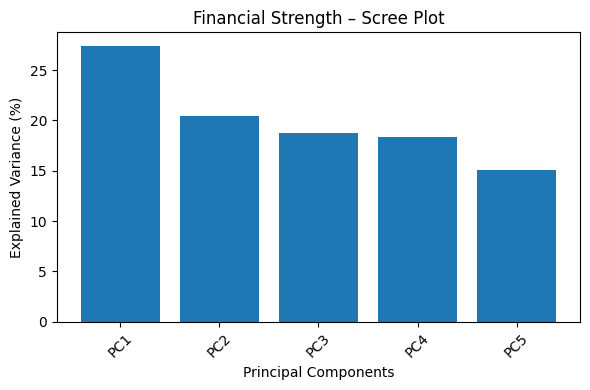

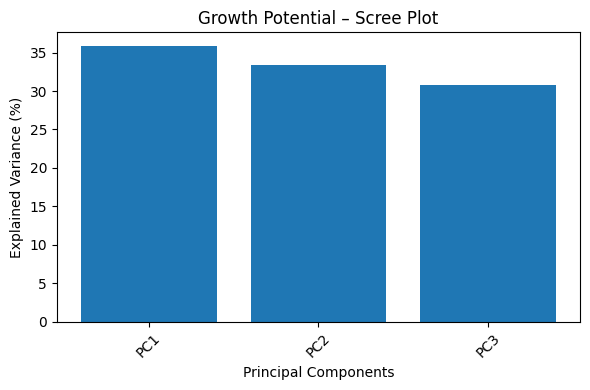

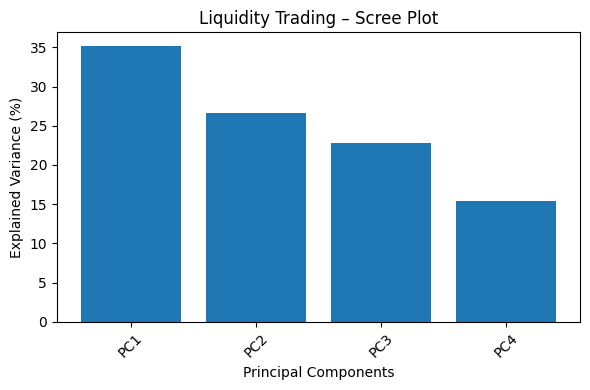

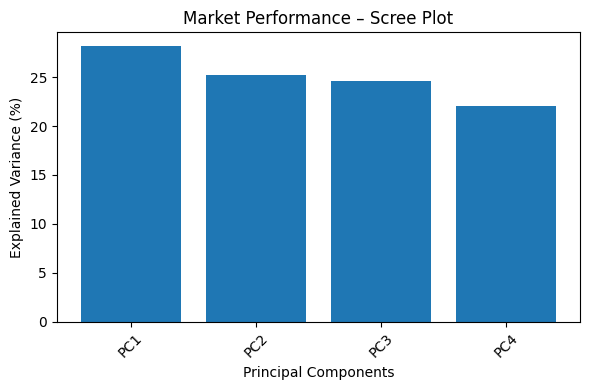

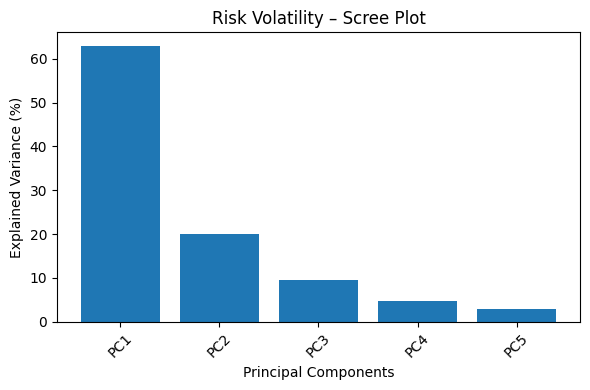

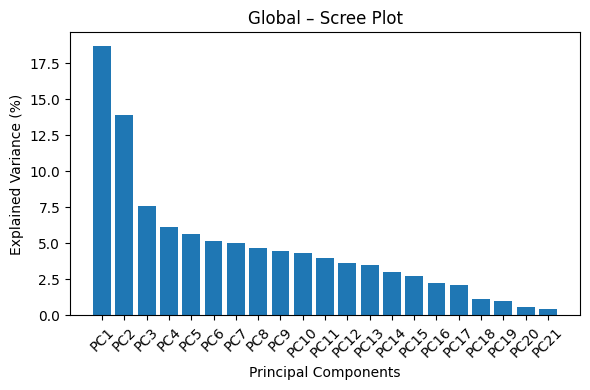

In [13]:
import pandas as pd, json
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

ROOT        = Path("..")
PROC_DIR    = ROOT / "data" / "processed"
INPUT_ALL   = PROC_DIR / "csiai_input_complete.parquet"
PCA_INPUT   = PROC_DIR / "csiai_input_pca.parquet"
PCA_Z       = PROC_DIR / "csiai_input_pca_zscores.parquet"
ART_PCA_DIR = ROOT / "artifacts" / "pca"
ART_PCA_DIR.mkdir(parents=True, exist_ok=True)

df_all = pd.read_parquet(INPUT_ALL)
if "ticker" in df_all.columns:
    df_all = df_all.set_index("ticker")


drop_vars = ["quick_ratio", "total_revenue", "analyst_rating", "rnd_to_revenue","ev_to_ebitda", "pb_ratio", "sharpe_ratio", "turnover_ratio", "shares_outstanding"]

df_pca = df_all.drop(columns=drop_vars)

# Save cleaned PCA input
df_pca.to_parquet(PCA_INPUT)

scaler = StandardScaler()
Z = pd.DataFrame(scaler.fit_transform(df_pca),index=df_pca.index,columns=df_pca.columns)
Z.to_parquet(PCA_Z)

meta = json.load(open(ROOT/"docs"/"metadata"/"variable_dictionary.json"))
GROUPS = {
    dim: [var for var, info in meta.items() if info["dim"] == dim and var in Z.columns]
    for dim in sorted({info["dim"] for info in meta.values()})
}

# helper to plot bar‐chart scree
def bar_scree(evr, title, outpath):
    per_var = evr.values * 100
    labels  = evr.index.tolist()
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(per_var)+1), per_var, tick_label=labels)
    plt.ylabel("Explained Variance (%)")
    plt.xlabel("Principal Components")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    plt.close()

# pca for the sub-indices
for dim, cols in GROUPS.items():
    pca = PCA()
    pca.fit(Z[cols])

    # explained variance & loadings
    evr = pd.Series(pca.explained_variance_ratio_,
                    index=[f"PC{i+1}" for i in range(len(cols))])
    evr.to_csv(ART_PCA_DIR / f"{dim}_explained_variance.csv")
    loadings = pd.DataFrame(pca.components_.T, index=cols,
                            columns=evr.index)
    loadings.to_csv(ART_PCA_DIR / f"{dim}_loadings.csv")

    # bar‐chart scree
    bar_scree(evr, title=f"{dim.replace('_',' ').title()} – Scree Plot", outpath=ART_PCA_DIR / f"{dim}_scree.png")

# pca for the global dataset
pca_all = PCA()
pca_all.fit(Z)
evr_all = pd.Series(pca_all.explained_variance_ratio_,
                    index=[f"PC{i+1}" for i in range(Z.shape[1])])
evr_all.to_csv(ART_PCA_DIR / "global_explained_variance.csv")
loadings_all = pd.DataFrame(pca_all.components_.T,
                            index=Z.columns,
                            columns=evr_all.index)
loadings_all.to_csv(ART_PCA_DIR / "global_loadings.csv")

# global bar‐chart scree
bar_scree(evr_all, title="Global – Scree Plot", outpath=ART_PCA_DIR / "global_scree.png")

## 5.2 Interpretation of PCA Results

### 5.2.1 Financial Strength

- **PC1 (27.38 %)**  
  - High positive loadings on **EBITDA margin** (0.615) and **ROE** (0.567), moderate on operating cash flow (0.382).  
  - Captures a **profitability** axis.

- **PC2 (20.42 %)**  
  - Dominated by **Debt-to-Equity** (0.888).  
  - Reflects a **leverage** dimension.

- **PC3 (18.78 %)**  
  - Strong on **Operating Cash Flow** (0.788).  
  - Represents a **cash-flow** signal.

- **Cumulative (PC1+PC2+PC3 ≈ 66 %)**  
  - Retaining the first three PCs gives a compact but informative representation of financial strength.